In [ ]:
using LinearAlgebra, Random, Statistics, DelimitedFiles#, POPSRegression;
using JSON, Unitful;
using AtomsBuilder, GeomOpt, AtomsCalculators, AtomsBase;
using AtomsCalculators: potential_energy, forces, virial;
using ACEpotentials;
using AtomsBase: FlexibleSystem, FastSystem, position;
using AtomsBase;
using StaticArrays;
using CairoMakie;
using DelimitedFiles
using LinearSolve

: 

In [2]:
function corrections(X, Y, Gamma; coeffs=nothing, leverage_percentile=0.0)
    C      = (Gamma' * Gamma ./ size(X, 1) .+ X' * X)
    A      = C \ X'
    leverage = diag(X * A)
    if (coeffs == nothing)
        coeffs = C \ (X' * Y)
    end
    errors = Y .- (X * coeffs)
    leverage_threshold = quantile(leverage, leverage_percentile)
    mask = leverage .>= leverage_threshold
    pointwise_corrections = A[:,mask]'
    pointwise_corrections = pointwise_corrections .* (errors[mask] ./ leverage[mask])
    return pointwise_corrections, coeffs
end

function hypercube(pointwise_corrections; percentile_clipping = 0.0)
    eig = eigen(Symmetric(pointwise_corrections' * pointwise_corrections))
    eigvals = eig.values
    eigvecs = eig.vectors

    mask = eigvals .> maximum(eigvals) * 1e-8
    eigvecs = eigvecs[:, mask]
    eigvals = eigvals[mask]

    projections = eigvecs
    projected = pointwise_corrections * projections

    lower = [quantile(projected[:, j], percentile_clipping / 100) for j in 1:size(projected, 2)]
    upper = [quantile(projected[:, j], 1.0 - percentile_clipping / 100) for j in 1:size(projected, 2)]

    bounds = vcat(lower', upper')

    return eigvecs, bounds
end

function sample_hypercube(projections, bounds, coeffs; number_of_committee_members = 50)
    lower, upper = bounds[1, :], bounds[2, :]

    U = rand(Float64, (number_of_committee_members, size(lower, 1)))

    committee = projections * (lower[:, :]' .+ (upper .- lower)[:,:]' .* U)'
    δθ        = committee * committee' ./ size(committee, 2)

    committee = coeffs[:,:] .+ committee
    
    return committee, δθ  
end;

In [3]:
function read_model(totaldegree; suffix = "_dia_with_test_set_aside_total_degree_$totaldegree.csv", folder = "Si_totdeg_$(totaldegree)")
    model = ace1_model(elements = [:Si,],
                       order = 4, totaldegree = totaldegree,
                       rcut = 6.0)
    Ap = readdlm("./$(folder)/design_matrix$suffix",  ',')
    Y  = readdlm("./$(folder)/Y$suffix",              ',')
    P  = readdlm("./$(folder)/prior$suffix",          ',')
    Y = Y[:,1]
    params = P \ (Ap \ Y)
    return model, Ap, Y, P
    ACEpotentials.Models.set_linear_parameters!(model, params)
end

read_model (generic function with 1 method)

In [9]:
Si_tiny_dataset, _, _ = ACEpotentials.example_dataset("Si_tiny");

In [10]:
ExtXYZ.save("Si_tiny.xyz", Si_tiny_dataset)

In [3]:
using ExtXYZ
Si_dataset = ExtXYZ.load("../Si_dataset.xyz");
deleteat!(Si_dataset, 1);

┌ Warning: 'pbc' not contained in dict. Defaulting to all-periodic boundary. 
└ @ ExtXYZ ~/.julia/packages/ExtXYZ/DB3mM/src/atoms.jl:156


In [4]:
config_types = Set([])
for (i, config) in enumerate(Si_dataset)
    if !(config[:config_type] in config_types)
        push!(config_types, config[:config_type])
    end
    try
        println(config[:dft_force])
    catch
    end
end
config_types

Set{Any} with 26 elements:
  "sh"
  "vacancy"
  "surface_110"
  "sp2"
  "fcc"
  "bt"
  "crack_110_1-10"
  "dia"
  "divacancy"
  "interstitial"
  "hcp"
  "surface_111_3x3_das"
  "amorph"
  "decohesion"
  "111adatom"
  "sp"
  "liq"
  "surface_001"
  "bc8"
  "st12"
  "surface_111"
  "screw_disloc"
  "crack_111_1-10"
  "hex_diamond"
  "surface_111_pandey"
  "bcc"

In [5]:
collected_types = collect(config_types)
number_of_each = [0 for i = 1:length(collected_types)]
number_of_configs = [0 for i = 1:length(collected_types)]
for (i, config) in enumerate(Si_dataset)
    arg = findfirst(==(config[:config_type]), collected_types)
    number_of_each[arg] += length(config)
    number_of_configs[arg] += 1
end

In [6]:
total_atoms = sum(number_of_each)
fraction_of_each = number_of_each ./ total_atoms
number_of_configs_each = Int64.(ceil.(fraction_of_each .* number_of_configs));
data_set = []
current = 1
for (i, config_type) in enumerate(collect(config_types))
    type_arr = []
    current = 1
    for (j, config) in enumerate(Si_dataset)
        if (config_type == config[:config_type] && current <= number_of_configs_each[i] && length(config) > 1)
            push!(type_arr, config)
            current += 1
        end
    end
    append!(data_set, type_arr)
end
;

In [ ]:
using ExtXYZ
using DelimitedFiles
if !isfile("Si_dataset.xyz")
    download("https://www.dropbox.com/scl/fi/z6lvcpx3djp775zenz032/Si-PRX-2018.xyz?rlkey=ja5e9z99c3ta1ugra5ayq5lcv&st=cs6g7vbu&dl=1",
         "Si_dataset.xyz");
end

Si_dataset = ExtXYZ.load("Si_dataset.xyz");
deleteat!(Si_dataset, 1);

dia_Si = []
vac_Si = []
div_Si = []
comm_num = 50
for i=1:length(Si_dataset)   
    if (Si_dataset[i][:config_type]=="dia")
        append!(dia_Si, i)
    elseif (Si_dataset[i][:config_type]=="divacancy")
        append!(div_Si, i)
    elseif (Si_dataset[i][:config_type]=="vacancy")
        append!(vac_Si, i)
    end
    
end

#test_ind = readdlm("./Si_totdeg_14/test_indices.csv", ',')[:,1]

Si_dataset  = vcat(Si_dataset[dia_Si], vcat(Si_dataset[vac_Si], Si_dataset[div_Si]))
test        = deepcopy(Si_dataset[1:10:length(Si_dataset)])
train       = deepcopy(Si_dataset[setdiff(1:length(Si_dataset), 1:10:length(Si_dataset))]);
#calib = deepcopy(test[1:2:end])
#test  = test[1:2:length(test) .+ 1];

┌ Warning: 'pbc' not contained in dict. Defaulting to all-periodic boundary. 
└ @ ExtXYZ ~/.julia/packages/ExtXYZ/DB3mM/src/atoms.jl:156


In [14]:
model = ace1_model(elements = [:Si,], order = 4, totaldegree = 8, rcut = 6.0)

ACEpotentials.Models.ACEPotential{ACEpotentials.Models.ACEModel{1, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64}}, ACEpotentials.Models.PolyEnvelope2sX{Float64}, 24, Float64}, Polynomials4ML.RealSCWrapper{SpheriCart.SphericalHarmonics{2, :L2, false, Float64}}, ACEpotentials.Models.SparseEquivTensor{Float64, Polynomials4ML.PooledSparseProduct{2}, Polynomials4ML.SparseSymmProdDAG}, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64}}, ACEpotentials.Models.ACE1_PolyEnvelope1sR{Float64}, 8, Float64}, ACEpotentials.Models.OneBody{Float64, Unitful.FreeUnits{(), NoDims, nothing}, Unitful.FreeUnits{(Å,), 𝐋, nothing}}}}(ACEpotentials.Models.ACEModel{1, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64}

In [17]:
if !isfile("Si_dataset.xyz")
    download("https://www.dropbox.com/scl/fi/z6lvcpx3djp775zenz032/Si-PRX-2018.xyz?rlkey=ja5e9z99c3ta1ugra5ayq5lcv&st=cs6g7vbu&dl=1",
         "Si_dataset.xyz");
end

Si_dataset = ExtXYZ.load("Si_dataset.xyz");
deleteat!(Si_dataset, 1);


┌ Warning: 'pbc' not contained in dict. Defaulting to all-periodic boundary. 
└ @ ExtXYZ ~/.julia/packages/ExtXYZ/DB3mM/src/atoms.jl:156


In [1]:
data_keys = (:dft_energy, :dft_force, :dft_virial)
smoothness = 4
prior = nothing
model = ace1_model(elements=[:Si], order=4, totaldegree=8, rcut=6.0)
train = ACEpotentials.make_atoms_data(Si_dataset[1:2], model; 
                          energy_key = data_keys[1], 
                          force_key = data_keys[2], 
                          virial_key = data_keys[3],
                          weights = Dict("default"=>Dict("E"=>30.0, "F"=>1.0, "V"=>1.0)))
P = ACEpotentials._make_prior(model, smoothness, prior)
A, Y, W = ACEfit.assemble(train, model)
solver=ACEfit.QR()
#acefit!([Si_dataset[end],], model; solver=solver)

LoadError: UndefVarError: `ace1_model` not defined

In [23]:
A

20×77 Matrix{Float64}:
  5.69342     4.29372     3.55731     …  -1.46924    -0.417079    1.25804
  0.0         0.0         0.0             0.0         0.0         0.0
  0.0         0.0         0.0             0.0         0.0         0.0
  0.0         0.0         0.0             0.0         0.0         0.0
  5.02592     1.86666     8.513          -6.73879     1.65394     4.46951
  5.03252     2.89608    10.6974      …  -6.4949      3.38679     3.28059
  5.16846     3.91653     7.09573        -1.05497     2.23197    -9.13532
  0.03316    -0.111278    0.0955157      -0.504976   -0.77517     0.791785
  0.0237015  -0.153799   -0.0914529      -0.425739   -0.831306    0.528263
 -0.011383   -0.788862   -1.6706         -0.16643    -1.26176     0.939795
  5.21929     4.17296     3.01431     …  -0.944109   -0.473778    0.986719
  0.0         0.0         0.0             0.0         0.0         0.0
  0.0         0.0         0.0             0.0         0.0         0.0
  0.0         0.0         0.0  

In [23]:
length(Si_dataset[1])

1

In [18]:
A

10×77 Matrix{Float64}:
  5.69342     4.29372    3.55731    …  -1.46924   -0.417079   1.25804
  0.0         0.0        0.0            0.0        0.0        0.0
  0.0         0.0        0.0            0.0        0.0        0.0
  0.0         0.0        0.0            0.0        0.0        0.0
  5.02592     1.86666    8.513         -6.73879    1.65394    4.46951
  5.03252     2.89608   10.6974     …  -6.4949     3.38679    3.28059
  5.16846     3.91653    7.09573       -1.05497    2.23197   -9.13532
  0.03316    -0.111278   0.0955157     -0.504976  -0.77517    0.791785
  0.0237015  -0.153799  -0.0914529     -0.425739  -0.831306   0.528263
 -0.011383   -0.788862  -1.6706        -0.16643   -1.26176    0.939795

In [ ]:
data_keys = (energy_key = "dft_energy", force_key = "dft_force", virial_key = "dft_virial")

#train = Si_dataset[1:20:end]
#test_set= Si_dataset[setdiff(1:length(Si_dataset), 1:20:length(Si_dataset))]
smoothness = 4
prior = nothing
model = ace1_model(elements = [:Si],
                        order = 4,
                        totaldegree = 16,
                        rcut = 6.0)
train = ACEpotentials.make_atoms_data(train, model; 
                          energy_key = data_keys[1], 
                          force_key = data_keys[2], 
                          virial_key = data_keys[3],
                          weights = Dict("default"=>Dict("E"=>30.0, "F"=>1.0, "V"=>1.0)))
appendix = "4"
if all(isfile.(["design_matrix_$appendix.csv", "W_$appendix.csv", "Y_$appendix.csv", "prior_$appendix.csv"]))
    println("Loading existing data files...")
    A = readdlm("design_matrix_$appendix.csv", ',')
    W = readdlm("W_$appendix.csv", ',')
    Y = readdlm("Y_$appendix.csv", ',')
    P = readdlm("prior_$appendix.csv", ',')
    W = W[:, 1]
    Y = Y[:, 1]
else
    println("Assembling data...")
    P = ACEpotentials._make_prior(model, smoothness, prior)
    A, Y, W = ACEfit.assemble(train, model)
    writedlm("design_matrix_$appendix.csv", A, ',')
    writedlm("W_$appendix.csv", W, ',')
    writedlm("Y_$appendix.csv", Y, ',')
    writedlm("prior_$appendix.csv", P, ',')
end

Ap = Diagonal(W) * (A/P)
Y = W .* Y

Assembling data...


[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (48380, 1461).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:13:52
[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


48380-element Vector{Float64}:
 -6920.519397068254
     0.3283
     0.85701
    -0.74716
    -0.3283
    -0.85701
     0.74716
    -0.12384401101776055
     1.4568674030693887
    -1.097192327441874
    -0.2675551911445864
     0.5887251064138427
     0.07935425948799756
     ⋮
    -0.24062
    -0.0158
    -0.09316
     0.04546
     0.16738
     0.15512
    31.356105616636132
    31.61376539638577
    31.497726092375256
    -0.5466293736094544
     0.5091182383315671
    -0.2199111511688022

In [7]:
appendix = "stratified_sampling"
A = readdlm("./design_matrix_$appendix.csv", ',')
W = readdlm("./W_$appendix.csv", ',')
Y = readdlm("./Y_$appendix.csv", ',')
P = readdlm("./prior_$appendix.csv", ',')

1461×1461 Matrix{Float64}:
 1.0   0.0   0.0    0.0    0.0     0.0  …      0.0      0.0      0.0      0.0
 0.0  16.0   0.0    0.0    0.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0  81.0    0.0    0.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0   0.0  256.0    0.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0  625.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0    0.0  1296.0  …      0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0    0.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0    0.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0    0.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0    0.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0    0.0     0.0  …      0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0    0.0     0.0         0.0      0.0      0.0      0.0
 0.0   0.0   0.0    0.0    0.0     0.

In [10]:
using ACEpotentials

In [8]:
model = ace1_model(elements = [:Si],
                        order = 4,
                        totaldegree = 16,
                        rcut = 6.0)

ACEpotentials.Models.ACEPotential{ACEpotentials.Models.ACEModel{1, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64}}, ACEpotentials.Models.PolyEnvelope2sX{Float64}, 91, Float64}, Polynomials4ML.RealSCWrapper{SpheriCart.SphericalHarmonics{4, :L2, false, Float64}}, ACEpotentials.Models.SparseEquivTensor{Float64, Polynomials4ML.PooledSparseProduct{2}, Polynomials4ML.SparseSymmProdDAG}, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64}}, ACEpotentials.Models.ACE1_PolyEnvelope1sR{Float64}, 16, Float64}, ACEpotentials.Models.OneBody{Float64, Unitful.FreeUnits{(), NoDims, nothing}, Unitful.FreeUnits{(Å,), 𝐋, nothing}}}}(ACEpotentials.Models.ACEModel{1, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64

In [10]:
lin_params = P \ (Ap \ Y)
ACEpotentials.Models.set_linear_parameters!(model, lin_params);

In [9]:
ACEpotentials.Models.set_committee!(model, co_ps_vec)

ACEpotentials.Models.ACEPotential{ACEpotentials.Models.ACEModel{1, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64}}, ACEpotentials.Models.PolyEnvelope2sX{Float64}, 91, Float64}, Polynomials4ML.RealSCWrapper{SpheriCart.SphericalHarmonics{4, :L2, false, Float64}}, ACEpotentials.Models.SparseEquivTensor{Float64, Polynomials4ML.PooledSparseProduct{2}, Polynomials4ML.SparseSymmProdDAG}, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64}}, ACEpotentials.Models.ACE1_PolyEnvelope1sR{Float64}, 16, Float64}, ACEpotentials.Models.OneBody{Float64, Unitful.FreeUnits{(), NoDims, nothing}, Unitful.FreeUnits{(Å,), 𝐋, nothing}}}}(ACEpotentials.Models.ACEModel{1, ACEpotentials.Models.SplineRnlrzzBasis{1, ACEpotentials.Models.NormalizedTransform{Float64, ACEpotentials.Models.GeneralizedAgnesiTransform{Float64

In [9]:
W = W[:,1]
Y = Y[:,1]
Ap = Diagonal(W) * (A/P)
Y = W .* Y

35477-element Vector{Float64}:
 -13812.934842189317
     -0.16249497
     -1.34303671
      0.2059745
     -0.12638397
     -0.33715163
     -0.10898614
      0.8574044
      0.74407812
     -0.10808889
     -0.18235533
     -0.33793462
     -0.16139201
      ⋮
      0.27722
      0.03286
     -0.47909
     -0.27722
     -0.03286
      0.47909
      0.012488672481943387
     -0.6010903958335367
     -0.18864309259793266
     -0.05568793999390532
     -0.18543730379727064
      0.00869437284943543

In [47]:
sort(leverage)[Int(floor(length(leverage)/100)):end]

35124-element Vector{Float64}:
 1.0427429735417206e-17
 1.0427429995359234e-17
 1.0427430396602102e-17
 1.0427431812814991e-17
 1.042743284632941e-17
 1.1794235497754736e-17
 1.1794241420323074e-17
 1.179424182644889e-17
 1.1794241952199048e-17
 1.1794242369485324e-17
 1.1794242379028548e-17
 1.1794243079510293e-17
 1.1794243443154821e-17
 ⋮
 0.8081949401378741
 0.8147939578498264
 0.8161001722685217
 0.852047585175848
 0.8531031732842485
 0.8549825347345892
 0.8666724075172059
 0.9191767069929817
 0.9495654535866689
 0.9747230691510853
 0.9853929525631038
 0.9914293477584234

In [52]:
errors[7975]

2.999999957940036e-5

In [58]:
A[:,7975]' * errors[7975]  / leverage[7975]  

1×1461 adjoint(::Vector{Float64}) with eltype Float64:
 2.50866e10  -1.09379e11  2.14344e10  …  -351.001  -187.574  253.478

In [40]:
leverage[7975], leverage[7984]

(1.7901398624759188e-31, 4.0685912350998815e-31)

In [11]:
Gamma = P
X = Ap
C      = (Gamma' * Gamma ./ size(X,1) .+ X' * X)
A      = C \ X'
leverage = diag(X * A)
coeffs = (Ap \ Y)

errors = Y .- (X * coeffs)
leverage_threshold = quantile(leverage, 0.5)
mask = leverage .>= leverage_threshold
pointwise_corrections = A[:,mask]' .* (errors[mask] ./ leverage[mask])
for i in 1:size(pointwise_corrections,1)
    pointwise_corrections[i,:] .+= coeffs
end
pointwise_corrections = (P \ pointwise_corrections')'
co_ps_vec = [pointwise_corrections[i,:] for i in 1:size(pointwise_corrections,1)]
# coeffs = (P \ coeffs)
# pointwise_corrections = [pointwise_corrections[i,:] .+ coeffs for i = 1:size(pointwise_corrections,1)]

17739-element Vector{Vector{Float64}}:
 [6479.861844316842, -3871.3287116141933, 463.31689240827524, -251.1261042537998, 151.51260878253265, -59.42470416270113, 103.47296652931763, -131.23624331291475, 116.79043410402616, -84.7987397380624  …  -27.770806349629964, 139.98746142331458, -76.62783709528367, -12.743133602041402, 51.510986484028706, -27.25667040279077, 17.87636628470703, -14.672427710953613, 6.244356090404668, -1.0214379617438865]
 [6479.902156211726, -3871.3654504894157, 463.3157665181101, -251.12612999535446, 151.51260841982224, -59.42470400122156, 103.47296656780664, -131.23624330823452, 116.79043410531456, -84.79873973748768  …  -27.770806349461534, 139.9874614230383, -76.62783709534551, -12.743133602053138, 51.51098648403578, -27.256670402789428, 17.876366284707366, -14.672427710952958, 6.244356090404376, -1.0214379617442284]
 [6479.835285884682, -3871.2932638831053, 463.31626531833035, -251.1261267561845, 151.512607419454, -59.42470431322784, 103.47296651546287, -131.2

In [ ]:
Y = Y[:, 1]
W = W[:, 1]
Ap = Diagonal(W) * (A/P)
Y = W .* Y
coeffs = P \ (Ap \ Y)
model = deepcopy(model[1])
ACEpotentials.Models.set_linear_parameters!(model, coeffs);
# ACEpotentials.save_model(model, "./Si_totdeg_$(totaldegree)/Si_model_$(appendix).json")

In [34]:
potential_energy(bulk(:Si), model)

-326.3398213592518 eV

In [13]:
coeffs = P \ (Ap \ Y)
ACEpotentials.Models.set_linear_parameters!(model, coeffs);

In [3]:
totaldegree = 10

10

In [4]:
model, Ap, Y, P = read_model(totaldegree);
params = P\(Ap\Y);

In [5]:
params = coeffs;

LoadError: UndefVarError: `coeffs` not defined

In [44]:
function POPS_percentile_clipping_calculator(params, model, test, percentile_clipping; corr_ = nothing)
    leverage_percentile = 0.5; lev = 0.5;
    if (corr_ == nothing)
        corr_, _ = corrections(Ap, Y, P; leverage_percentile = leverage_percentile, coeffs = nothing);
        corr_ = (P \ corr_')';
    end
    hypercube_support, hypercube_bounds = hypercube(corr_; percentile_clipping = percentile_clipping);
    committee, misspec_sigma = sample_hypercube(hypercube_support, hypercube_bounds, params);
    co_coeffs = committee
    co_ps_vec = [ co_coeffs[:,i] for i in 1:size(co_coeffs,2) ];
    set_committee!(model, co_ps_vec);
    test_E = []
    test_E_predictions = []
    test_co_E_predictions = []
    ev_val = counter = 0  
    co_E_range = []
    for (i, at) in enumerate(test)
        energy = at[:dft_energy]
        push!(test_E, energy)
        E, co_E= @committee potential_energy(at, model)
        push!(test_E_predictions, ustrip(E) - energy)
        push!(test_co_E_predictions, ustrip.(co_E) .- ustrip(E))
        push!(co_E_range, abs(maximum(ustrip.(co_E)) - minimum(ustrip.(co_E))))
        if (ustrip(E) > minimum(ustrip.(co_E)) && ustrip(E) < maximum(ustrip.(co_E)))
            counter += 1
        else
            ev_val +=  1
            counter += 1
        end
    end
    ev_val /= counter
    ev_val *= 100
    xdata = abs.(test_E_predictions)
    ydata = co_E_range ./ 2
    
    count_greater = sum(x .> y for (x, y) in zip(xdata, ydata))
    percentage = 100 * count_greater / length(xdata)
    
    return ev_val, percentage
end

POPS_percentile_clipping_calculator (generic function with 1 method)

In [48]:
percentile_clipping = 0.0
ev_val_              = 1.0
test_violations_     = 1.0
ev_val               = 0.0
test_violations      = 0.0
corr_ = corrections(Ap, Y, P; leverage_percentile = 0.5);
while (ev_val_ >= ev_val && test_violations_ >= test_violations)
    ev_val, test_violations = POPS_percentile_clipping_calculator(params, model, test, percentile_clipping; corr_ = corr_)
    println(ev_val, " ", test_violations, " ", percentile_clipping)
    global percentile_clipping += 0.5
end
percentile_clipping -= 1.0

0.0 0.0 0.0
0.0 4.081632653061225 0.5


0.0

In [ ]:
open("./Si_totdeg_$(totaldegree)/optimal_pc_$(percentile_clipping).txt", "w") do io
    write(io, percentile_clipping)
end


In [8]:
for nu = 2:4
    model = ace1_model(elements = [:Si],
                        order = nu,
                        totaldegree = 16,
                        rcut = 6.0)
    ACEpotentials.save_model(model, "./Si_model_$(nu).json")
end    

[ Info: saving project
[ Info: Results saved to file: ./Si_model_2.json
[ Info: saving project
[ Info: Results saved to file: ./Si_model_3.json
[ Info: saving project
[ Info: Results saved to file: ./Si_model_4.json


In [97]:
counter = 0
for (i, N) in enumerate(Int.(collect(masked_indices .== 0)))
    if N == 1
        println(i)
        counter += 1
    end
end

7723
7798
7963
7966
7969
7972
7975
7978
7981
7984
9829
9830
9853
9854
9895
9896
9919
9920
9943
9944
10033
10034
10057
10058
10081
10082
10099
10100
10123
10124
15273
15274
15279
15281
15286
15287


In [98]:
counter

36

In [ ]:
function corrections(X, Y, Gamma; coeffs=nothing, leverage_percentile=0.0)
    C      = (Gamma' * Gamma ./ size(X, 1) .+ X' * X)
    A      = C \ X'
    leverage = diag(X * A)
    if (coeffs == nothing)
        coeffs = C \ (X' * Y)
    end
    errors = Y .- (X * coeffs)
    leverage_threshold = quantile(leverage, leverage_percentile)
    # mask = leverage .>= leverage_threshold
    # test = ones(length(errors))
    # test[rand(1:length(errors))] = 0
    # mask = test .== 1
    pointwise_corrections = A[:,mask]'
    pointwise_corrections = pointwise_corrections .* (errors[mask] ./ leverage[mask])
    return pointwise_corrections, coeffs, mask
end
;

corrections (generic function with 1 method)

In [152]:
X = [1 2; 3 4]

2×2 Matrix{Int64}:
 1  2
 3  4

In [157]:
transpose(X) .* [1,2]

2×2 Matrix{Int64}:
 1  3
 4  8

In [171]:
quantile([1,4,3,4], 0.5)

3.5

This works:

In [228]:
function corrections(X, Y, Gamma; coeffs=nothing, leverage_percentile=0.0)
    C      = (Gamma' * Gamma ./ size(X, 1) .+ X' * X)
    A      = C \ X'
    leverage = diag(X * A)
    if (coeffs == nothing)
        coeffs = C \ (X' * Y)
    end
    errors = Y .- (X * coeffs)
    leverage_threshold = quantile(leverage, leverage_percentile)
    # mask = leverage .>= leverage_threshold
    # test = ones(length(errors))
    # test[rand(1:length(errors))] = 0
    # mask = test .== 1
    pointwise_corrections = transpose(A) .* (errors ./ leverage)
    return pointwise_corrections, coeffs
end

corrections (generic function with 1 method)

Trial improvements: 

In [190]:
function corrections(X, Y, Gamma; coeffs=nothing, leverage_percentile=0.0)
    C      = (Gamma' * Gamma ./ size(X, 1) .+ X' * X)
    A      = C \ X'
    leverage = diag(X * A)
    if (coeffs == nothing)
        coeffs = C \ (X' * Y)
    end
    errors = Y .- (X * coeffs)
    leverage_threshold = quantile(leverage, leverage_percentile)
    mask = leverage .>= leverage_threshold
    pointwise_corrections = (Gamma \ (A[:,mask]' .* (errors[mask] ./ leverage[mask]))')'
    return pointwise_corrections, coeffs
end

corrections (generic function with 1 method)

In [184]:
X = [1 2; 3 4]
pc = X[:, [1]]
pc = pc .* 2

2×1 Matrix{Int64}:
 2
 6

In [240]:
function corrections(X, Y, Gamma; coeffs=nothing, leverage_percentile=0.0)
    C      = (Gamma' * Gamma ./ size(X, 1) .+ X' * X)
    A      = C \ X'
    leverage = diag(X * A)
    if (coeffs == nothing)
        coeffs = C \ (X' * Y)
    end
    errors = Y .- (X * coeffs)
    leverage_threshold = quantile(leverage, leverage_percentile)
    mask = leverage .>= leverage_threshold
    pointwise_corrections = A[:,mask]' .* (errors[mask] ./ leverage[mask])
    return pointwise_corrections, coeffs, mask
end

corrections (generic function with 1 method)

In [107]:
config_inds = []

function data_arrangement!(train_data, config_inds; energy_key = :dft_energy, force_key = :dft_force, virial_key = :dft_virial)
    current_ind  = 0
    configs_seen = []
    for i = 1:length(train_data)
        inds = []
        sys  = train_data[i]
        energy_ind   = 1 + current_ind
        current_ind += 1
        if haskey(sys, :dft_force)
            force_ind = (current_ind + 1):(length(sys) * 3 + current_ind + 1)
            current_ind += length(sys) * 3
        else
            force_ind = nothing
        end
        virial_ind  = (current_ind + 1):(current_ind + 6)
        current_ind += 6
        inds = (energy_ind, force_ind, virial_ind)
        push!(config_inds, inds)
        if !(sys[:config_type] in configs_seen)
            println(sys[:config_type])
            push!(configs_seen, sys[:config_type])
        end
    end
    println(current_ind)
end
data_arrangement!(data_set, config_inds)

sh
vacancy
surface_110
sp2
fcc
bt
crack_110_1-10
dia
divacancy
interstitial
hcp
surface_111_3x3_das
amorph
decohesion
111adatom
sp
liq
surface_001
bc8
st12
surface_111
screw_disloc
crack_111_1-10
hex_diamond
surface_111_pandey
bcc
1484


In [23]:
# --- 1. SVD of X (Python uses Vh = V^T) ---
U, S, Vt = svd(X)          # X = U * Diagonal(S) * Vt

# eigen_vals_ in Python are singular values squared
eigen_vals_ = S .^ 2
alpha_ = 1

# scaled_sigma_ = Vh.T * (Vh / (eigen_vals_ + lambda_/alpha_)[:,None])
# In Julia: Vh = Vt, so Vh.T = Vt'
reg = eigen_vals_ .+ lambda_ / alpha_
scaled_sigma_ = Vt' * (Vt ./ reg')

# --- 2. Compute model coefficients ---
# Python uses: coef_ = solution of ridge or similar
# We'll match: coeffs = (X'X + λI)^(-1) X'y
coeffs = (X'X + (lambda_/alpha_)*I) \ (X' * Y)

# --- 3. Compute residual errors (same as Python) ---
errors = Y .- X * coeffs

# --- 4. Compute AD = X @ scaled_sigma_ ---
AD = X * scaled_sigma_

# --- 5. Leverage = sum(AD * X, axis=1) ---
# Elementwise product rowwise sum:
leverage = sum(AD .* X, dims=2)
leverage = vec(leverage)  # convert to 1D

# --- 6. Apply percentile threshold like Python ---
leverage_threshold = quantile(leverage, 0)#leverage_percentile/100)
mask = leverage .>= leverage_threshold

# --- 7. pointwise_correction = AD[mask] * errors[mask]
pointwise_correction = (P \ (AD[mask, :] .* errors[mask] ./ leverage[mask])')'

# (Python returns this directly; no coeffs added, no P-transforms)
for i in 1:size(pointwise_corrections,1)
    pointwise_correction[i,:] .+= lin_params
end

In [24]:
pointwise_correction

35477×1461 adjoint(::Matrix{Float64}) with eltype Float64:
 6479.86  -3871.33  463.317  -251.126  …  -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126  …  -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126  …  -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
 6479.86  -3871.33  463.317  -251.126     -14.6724  6.24436  -1.02144
    ⋮                          

In [119]:
Y = Y[:, 1]
W = W[:, 1]
Ap = Diagonal(W) * (A/P)
Y = W .* Y
coeffs = P \ (Ap \ Y)
#model = deepcopy(model[1])
ACEpotentials.Models.set_linear_parameters!(model, coeffs);
# ACEpotentials.save_model(model, "./Si_totdeg_$(totaldegree)/Si_model_$(appendix).json")

In [112]:
ACEpotentials.Models.set_linear_parameters!(model, coeffs);

In [281]:
leverage_percentile = 0.001; lev = 0.5;
corr_,_,masked_indices = corrections(Ap, Y, P; leverage_percentile = leverage_percentile);
corr_ = (P \ corr_')';

In [202]:
corr_ = (P \ corr_')';

In [16]:
#co_ps_vec = [corr_[i,:] .+ coeffs for i = 1:size(corr_,1)]
ACEpotentials.Models.set_committee!(model, co_ps_vec);

In [133]:
percentile_clipping = 0.0

0.0

In [139]:
hypercube_support, hypercube_bounds = hypercube(corr_; percentile_clipping = percentile_clipping);

committee, misspec_sigma = sample_hypercube(hypercube_support, hypercube_bounds, coeffs);
co_coeffs = committee
co_ps_vec = [ co_coeffs[:,i] for i in 1:size(co_coeffs,2) ];
set_committee!(model, co_ps_vec);

In [60]:
ACEpotentials.Models.set_committee!(model, co_ps_vec);

In [13]:
counter =0
for i in co_E
    if (ustrip(i) > -300 || ustrip(i) < -350)
        # println("S")
        counter +=1 
    end
end
counter

30

In [65]:
leverage

35477-element Vector{Float64}:
 0.2305811666023625
 0.004606720782167601
 0.017700516656917728
 0.0038943862316940473
 0.00966655504513126
 0.012281336097972155
 0.00293717952898826
 0.011632483678370806
 0.01077608660313767
 0.005766804885212029
 0.008733734004028298
 0.018673457786736056
 0.005151791547207088
 ⋮
 0.025354225816677282
 0.003241578481335164
 0.10841243091791945
 0.025354225816675808
 0.0032415784813350805
 0.10841243091791129
 0.2501076910234663
 0.24384331477550275
 0.26204793647713986
 0.0026904352782069203
 0.020384607189096397
 0.0006672439280633494

In [61]:
E, co_E = @committee potential_energy(bulk(:Si), model)

(-326.3398213591863 eV, Quantity{Float64, 𝐋^2 𝐌 𝐓^-2, Unitful.FreeUnits{(eV,), 𝐋^2 𝐌 𝐓^-2, nothing}}[-326.33981299983515 eV, -326.3392026202714 eV, -326.3397536347148 eV, -326.3405229264841 eV, -326.3396791132079 eV, -326.3400849811427 eV, -326.33985258301385 eV, -326.33981699233584 eV, -326.3400766068592 eV, -326.3396461781684 eV  …  -326.33991031137754 eV, -326.3397846077832 eV, -326.3397407436099 eV, -326.3399103113721 eV, -326.3397846077832 eV, -326.3398000441559 eV, -326.3398558692 eV, -326.33980476826 eV, -326.3395665274915 eV, -326.3398286784846 eV])

In [111]:
function findlargest2(a::AbstractVector)
    @assert length(a) >= 2
    i1, i2 = 1, 2
    max1, max2 = a[i1], a[i2]
    if max1 < max2
        max1, max2 = max2, max1
    end
    for i = 3:length(a)
        ai = a[i]
        if ai > max2
            if ai > max1
                i1, i2 = i, i1
                max1, max2 = ai, max1
            else
                i2 = i
                max2 = ai
            end
        end
    end
    return i1, i2
end
function findsmalles2(a::AbstractVector)
    @assert length(a) >= 2
    i1, i2 = 1, 2
    min1, min2 = a[i1], a[i2]
    if min1 > min2
        min1, min2 = min2, min1
    end
    for i = 3:length(a)
        ai = a[i]
        if ai < min2
            if ai < min1
                i1, i2 = i, i1
                min1, min2 = ai, min1
            else
                i2 = i
                min2 = ai
            end
        end
    end
    return i1, i2
end

findsmalles2 (generic function with 1 method)

In [113]:
findlargest2(leverage), findsmalles2(errors)

((32157, 7960), (9160, 8578))

In [29]:
using Statistics
vars = []
corr_= reduce(hcat, co_ps_vec)
for i = 1:size(corr_, 2)
    push!(vars, var(corr_[:,i]))
end

In [284]:
mags = []
for i = 1:size(corr_, 2)
    push!(mags, sum(corr_[:,i] .^ 2))
end

In [285]:
findlargest2(mags)

(1, 2)

In [32]:
corr_[:, 7975]

1461-element Vector{Float64}:
      2.6051288123740463e10
     -1.8860129020032723e9
      2.472020883493248e9
     -5.0484235595839836e7
      2.7731719357693378e7
      2.1026445450044842e6
 148821.36700509617
  41363.40327623792
   6575.496209962224
   1620.2150971729338
    567.8377913319476
     64.7430200485507
     42.09758314540254
      ⋮
     -5.955006298819403e6
 181563.12831234554
  56841.67920835164
 -14852.217717433474
   2239.7943580228125
    232.682720636701
   -126.47774496575477
     18.23802235887554
     17.434848921835325
    -18.109503858959688
      8.152676716552856
     -1.4914662608406317

In [31]:
largest = findlargest2(vars)

(7975, 7984)

In [294]:
P1 = corr_[:, largest[1]]
P2 = corr_[:, largest[2]]
P3 = corr_[:, 3]

35441-element Vector{Float64}:
  0.00014609598105385152
  0.0014638184629673391
 -0.002827979573936336
  0.0006876503097571187
 -0.003911170706095122
 -0.0012185878642744876
  0.005636741873996198
 -0.00218248670739209
 -0.002619267093970211
  0.005994314822152617
  0.0020147283972625405
  0.0009854316204366506
 -0.0017682160676684984
  ⋮
 -0.0020740997633867404
 -0.0014123460825886474
 -0.003014779459951126
 -0.002074099763160751
 -0.0014123460822185539
 -0.003014779459255615
 -0.0005096081272055979
 -0.0004676164940712978
 -7.290236378477265e-5
  0.0005871103079301051
 -2.038483750457674e-5
 -0.0002175154967510601

In [ ]:
vectors_to_keep
for (i, vec) in enumerate([corr_[i,:] for i = 1:size(corr_,1)])


In [280]:
sqrt(vars[1])

1.675122686245263e8

In [63]:
length(co_ps_vec)

17739

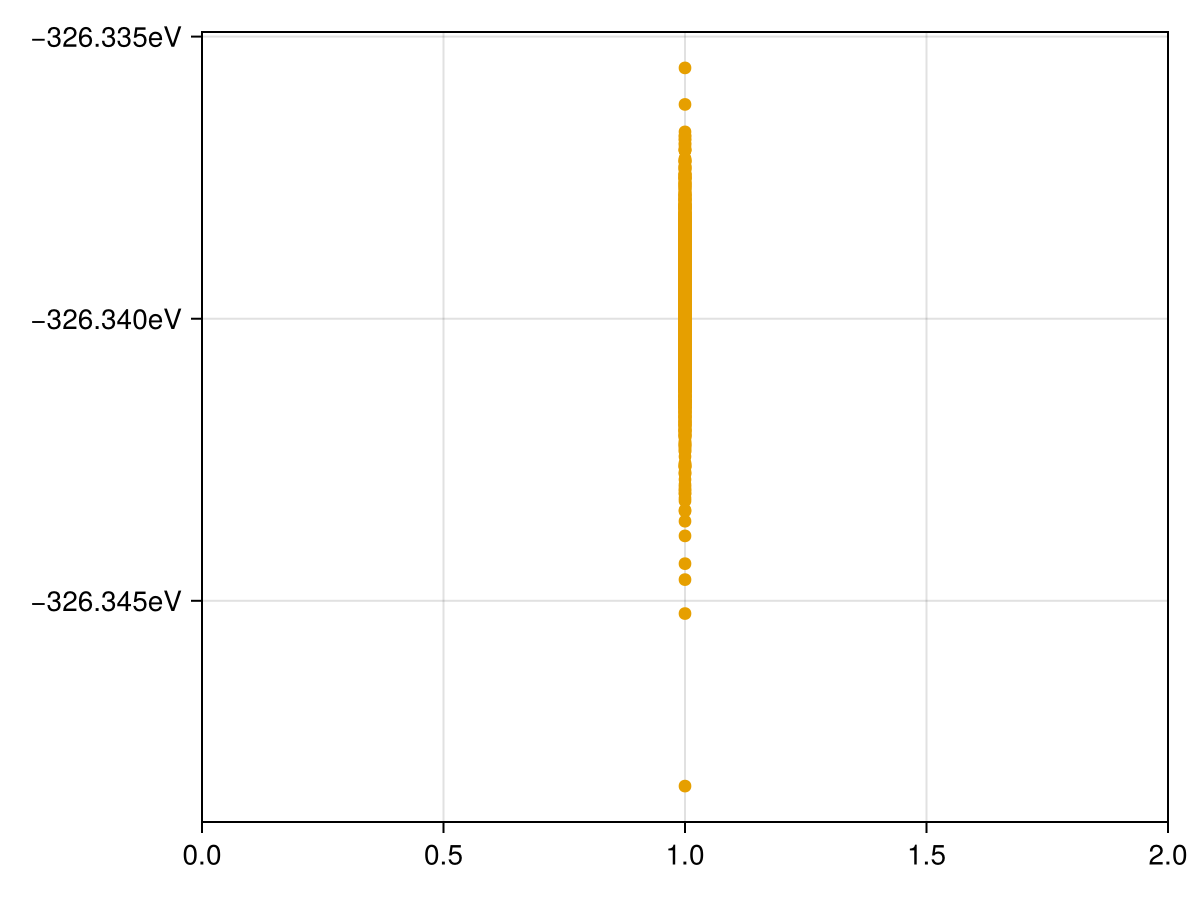

In [62]:
f = Figure()
x = ones(length(co_E))
plot(f[1,1], [1.,], [E,])
plot!(f[1,1], x, co_E)
f

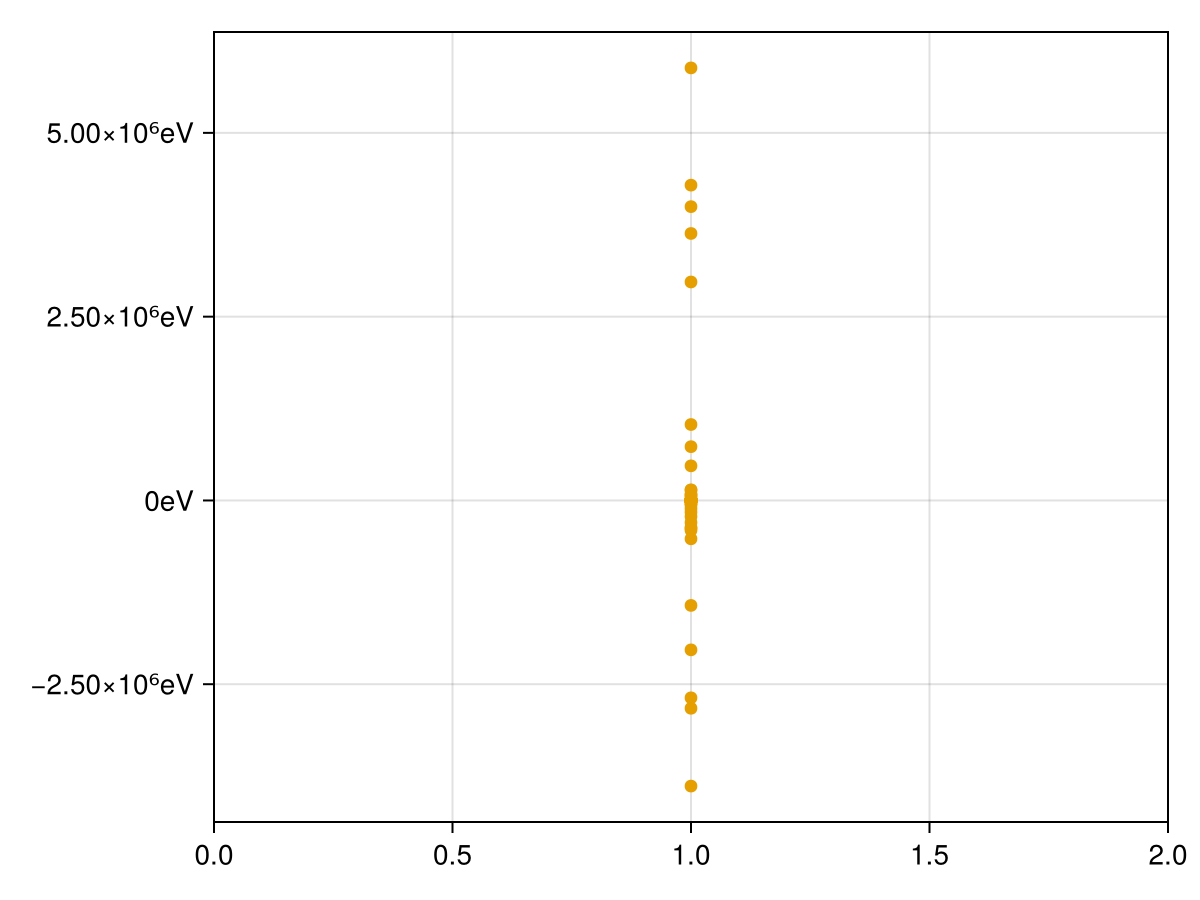

In [211]:
f = Figure()
x = ones(length(co_E))
plot(f[1,1], [1.,], [E,])
plot!(f[1,1], x, co_E)
f

In [66]:
norm2(vec) = sqrt(vec' * vec)
distances_of_coeff_vectors = [norm2(vec .- params) for vec in co_ps_vec];
distances_of_coeff_vectors = 1 .- distances_of_coeff_vectors .* 1 / maximum(distances_of_coeff_vectors);

LoadError: UndefVarError: `params` not defined

In [50]:
using AtomsCalculatorsUtilities.SitePotentials: hessian
Si = bulk(:Si)
ACEpotentials.Models.set_linear_parameters!(model, params)
remove_inds = []
for i = 1:50
    vec = co_ps_vec[i]
    ACEpotentials.Models.set_linear_parameters!(model, vec)
    are_eigvals_above_one = real(eigvals(ustrip.(hessian(Si, model)))) .> 0    
    if (all(are_eigvals_above_one))
        println(i, " is not a positive definite matrix!")
        push!(remove_inds, i)
    end
end

26 is not a positive definite matrix!
35 is not a positive definite matrix!


In [98]:
strains = collect(-5:5) .* 0.01
configs = []


11-element Vector{Float64}:
 -0.05
 -0.04
 -0.03
 -0.02
 -0.01
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05

In [82]:
dif = setdiff(1:50, remove_inds)
ACEpotentials.Models.set_linear_parameters!(model, params)
set_committee!(model, co_ps_vec[dif])
dif_co_ps_vec = co_ps_vec[dif];

48-element Vector{Vector{Float64}}:
 [260.83785545166813, -209.3286556647256, -30.573210633446095, -150.78210679611593, 110.4305175738534, -70.95398198366061, 16.24168884194829, -0.979594154998785, -12.399969431556048, 12.264346376158167  …  -11.020878912812504, -22.60836965274789, 15.034930923919573, -2.814897733593712, -1.270106982256815, 2.419626673366564, -1.7616891465868658, 1.7206224092634677, -1.1687982038001206, 0.33420520702122974]
 [261.2774531197945, -209.10650958225258, -30.571840021584737, -150.7820871210474, 110.43051993061381, -70.95398194724055, 16.24168884787116, -0.9795941311060126, -12.399969423289996, 12.264346377212659  …  -11.020878867136226, -22.608369645134736, 15.034930930051843, -2.8148977342750237, -1.2701069824390359, 2.4196266732990632, -1.761689146622359, 1.7206224092744704, -1.1687982037926532, 0.3342052070195377]
 [260.369857143106, -209.05136740957275, -30.57146341531276, -150.78210777311838, 110.43051934276336, -70.95398163109118, 16.241688862486985, -

In [22]:
writedlm("./Si_totdeg_$(totaldegree)/co_coeffs_$(appendix).csv", co_ps_vec, ',')

In [74]:
data_set[1]

Atoms(Si₈, pbc = TTT):
    bounding_box      : [ 2.91979 -4.76091 0.118916;
                          2.40446  4.65375 -0.00897;
                         0.103877 -0.029744  4.95497]u"Å"
    cutoff            : -1.0
    DFT_energy        : -1302.295986
    config_type       : sh
    DFT_virial        : [0.622283 3.4521 -1.75062; 3.4521 5.20082 0.78592; -1.75062 0.78592 -3.5532]
    nneightol         : 1.2

    AtomView(Si, [-1.29986,  1.26823,  1.47577]u"Å")
    AtomView(Si, [-1.83079,  1.25357, -0.95809]u"Å")
    AtomView(Si, [-0.710647,  3.46462,  1.65737]u"Å")
    AtomView(Si, [-0.107008,  3.62174, -0.827866]u"Å")
    AtomView(Si, [-0.420197, -1.33314,  1.60989]u"Å")
    AtomView(Si, [ 0.14177, -1.30671, -0.867994]u"Å")
    AtomView(Si, [ 1.38942, 0.937952,  1.54437]u"Å")
    AtomView(Si, [0.589205,   1.1399, -0.913631]u"Å")


In [88]:
test = data_set
test_E = []
test_E_predictions = []
test_co_E_predictions = []
ev_val = counter = 0  
co_E_range = []
for (i, at) in enumerate(test)
    try
        energy = at[:dft_energy]
    
        push!(test_E, energy)
        E, co_E= @committee potential_energy(at, model)
        push!(test_E_predictions, ustrip(E) - energy)
        push!(test_co_E_predictions, ustrip.(co_E) .- ustrip(E))
        push!(co_E_range, abs(maximum(ustrip.(co_E)) - minimum(ustrip.(co_E))))
        if (ustrip(E) > minimum(ustrip.(co_E)) && ustrip(E) < maximum(ustrip.(co_E)))
            counter += 1
        else
            ev_val +=  1
            counter += 1
        end
    catch
    end
    
end
ev_val /= counter
ev_val *= 100

0.0

In [8]:
function read_model(nu; suffix = "_$nu.csv")
    model = ace1_model(elements = [:Si,],
                       order = nu, totaldegree = 16,
                       rcut = 6.0)
    A = readdlm("./design_matrix$suffix",  ',')
    Y  = readdlm("./Y$suffix",              ',')
    P  = readdlm("./prior$suffix",          ',')
    W  = readdlm("./W$suffix",          ',')
    Y = Y[:,1]
    W = W[:, 1]
    Ap = Diagonal(W) * (A/P)
    Y = W .* Y
    
    params = P \ (Ap \ Y)
    ACEpotentials.Models.set_linear_parameters!(model, params)
    return model, Ap, Y, P
end

read_model (generic function with 1 method)

In [17]:
figs = []
fig = Figure()
ax  = Axis(fig[1,1], xlabel = "Correlation order", ylabel = "Bulk modulus / GPa")
datas = [2,3,4]
global lowerrors = []
global higherrors= []
global B_s       = []
for nu in [2, 3, 4]
    model, Ap, Y, P = read_model(nu)
    model_outline = deepcopy(model)
    params = P\(Ap\Y);
    percentile_clipping  = 0.0
    leverage_percentile = 0.5; lev = 0.5;
    corr_, _ = corrections(Ap, Y, P; leverage_percentile = leverage_percentile, coeffs = nothing);
    corr_ = (P \ corr_')';
    hypercube_support, hypercube_bounds = hypercube(corr_; percentile_clipping = percentile_clipping);
    
    committee, misspec_sigma = sample_hypercube(hypercube_support, hypercube_bounds, params);
    co_coeffs = committee
    co_ps_vec = [ co_coeffs[:,i] for i in 1:size(co_coeffs,2) ];
    set_committee!(model, co_ps_vec);
    writedlm("./co_coeffs_$nu.csv", co_ps_vec, ',')
    lattice_consts = cbrt.(gap_volumes * 8)
    volumes, energies, co_energies = volume_energy_curve_(element = :Si, lattice_consts_ = lattice_consts, model = model, num_in_committee = length(co_ps_vec));
    volumes_per_atom     = volumes     ./ 8
    energies_per_atom    = energies    ./ 8
    co_energies_per_atom = co_energies ./ 8
    coeffs, X = OLS(volumes_per_atom, energies_per_atom; degree=2)
    ace_V0, ace_e0, ace_B     = QoI(coeffs) ;
    bulk_committee  = []
    ace_v0_committee=[]
    for i = 1:length(co_ps_vec)
        coeffs_i, X_i = OLS(volumes_per_atom, co_energies_per_atom[:,i]; degree=2)
        ace_V0_i, ace_e0_i, ace_B_i     = QoI(coeffs_i)
        push!(bulk_committee, ace_B_i)
        push!(ace_v0_committee, ace_V0_i)
    end
    lowerror = minimum(bulk_committee)
    higherror= maximum(bulk_committee)
    push!(lowerrors,  lowerror)
    push!(higherrors, higherror)
    push!(B_s, ace_B)
end
lines!(ax, datas, ones(length(datas)).*gap_B_eos, linestyle = :dash)
errorbars!(ax, datas, B_s, lowerrors, higherrors, whiskerwidth = 10, color = :black)
scatter!(ax, datas, B_s)
save("./B_different_nu_1.png", fig)

In [19]:
higherrors

3-element Vector{Any}:
 NaN
 101.9289790222029
  89.00693153989442

In [18]:
lowerrors

3-element Vector{Any}:
 NaN
  69.60492501143929
  84.76669809177606

0.9914293477584234

In [16]:
figs = []
for totaldegree in [6, 10, 14]
    matrix = readdlm("./vary_Si_data_$(totaldegree)/B_vs_data_numbers.csv", ',')
    local datas  = matrix[1, :]
    local B_s    = matrix[2, :]
    fig = Figure()
    ax  = Axis(fig[1,1], xlabel = "Number of training configurations", ylabel = "Bulk modulus / GPa")
    lines!(ax, datas, ones(length(datas)).*gap_B_eos, linestyle = :dash, label = "DFT")
    errorbars!(ax, datas, B_s, lowerrors, higherrors, whiskerwidth = 10, color = :black)
    scatter!(ax, datas, B_s, color = :black)
    axislegend(ax)
    save("./vary_Si_data_$(totaldegree)/B_different_data.png", fig)
    push!(figs, fig)
end

┌ Warning: `.px_area` got renamed to `.viewport`, and means the area the scene maps to in device independent units, not pixels. Note, `size(scene) == widths(scene.viewport[])`
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/deprecated.jl:17


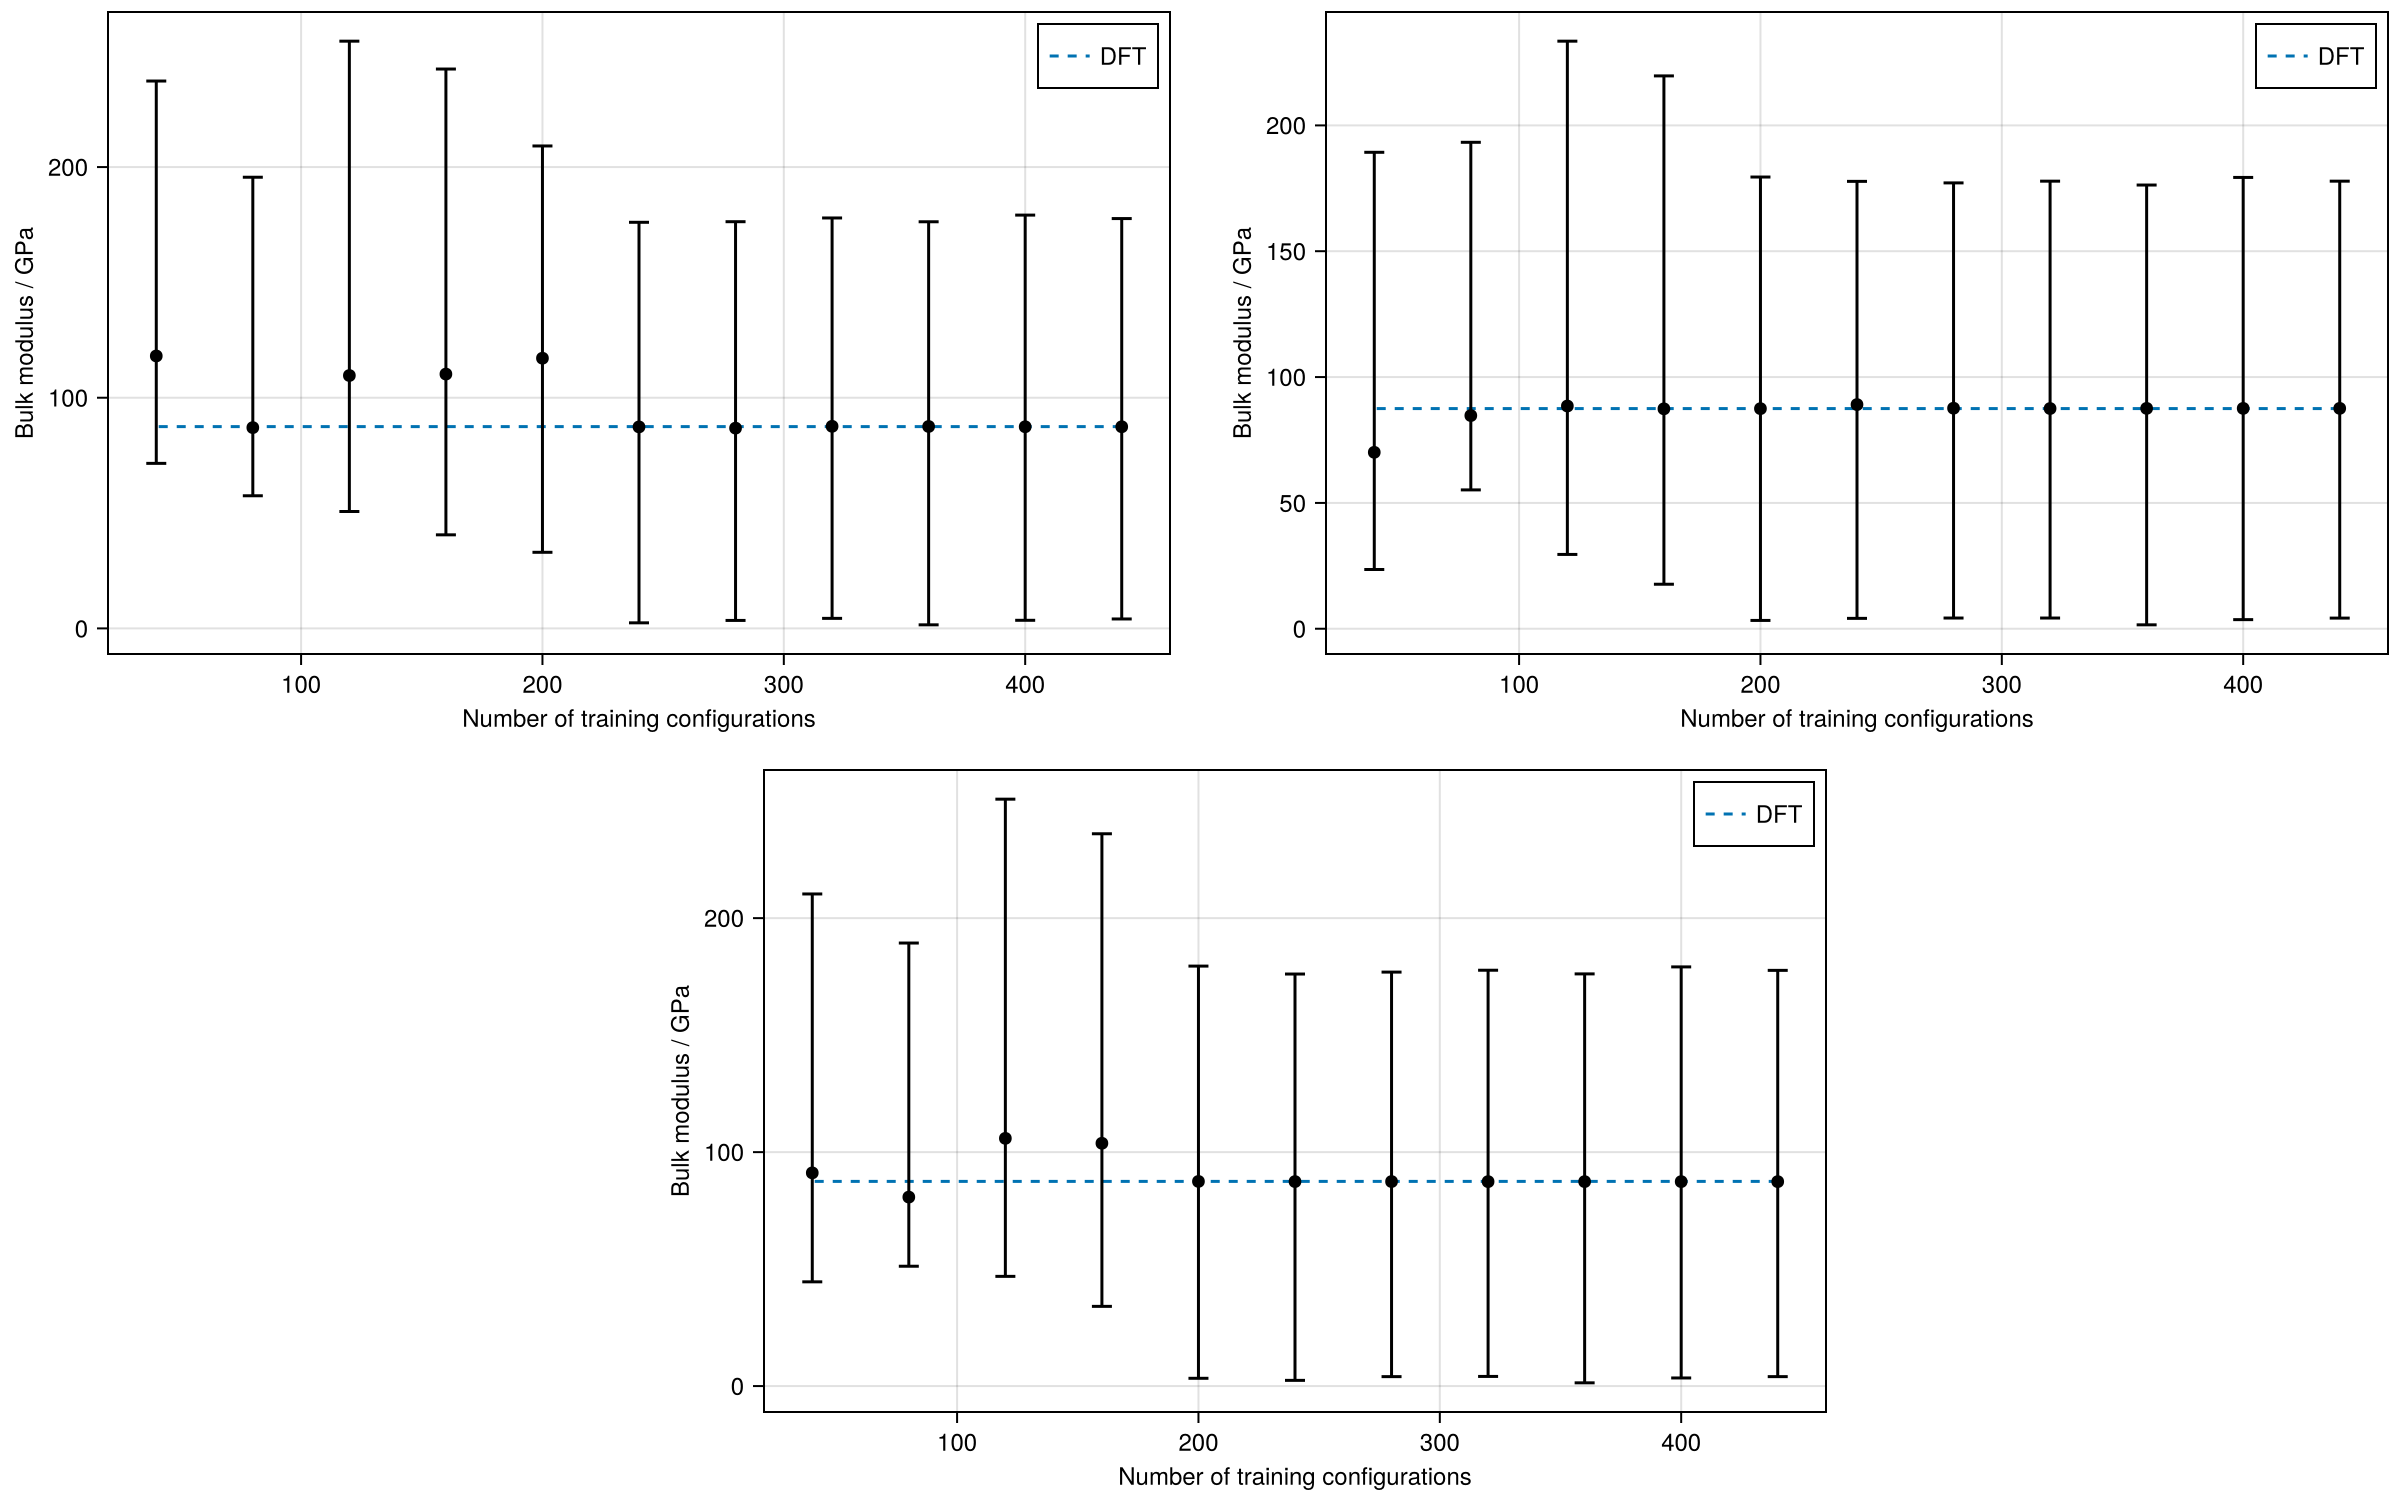

In [17]:
using CairoMakie

fig = Figure(; size = (1200, 750), fontsize = 12, figure_padding = 6)

# Top row: two axes in columns 1 and 3, with column 2 left as a spacer
ax1 = Axis(fig[1, 1], xlabel = "Number of training configurations", ylabel = "Bulk modulus / GPa")
Box(fig[1, 2], width = 20, visible = false)  # Spacer column
ax2 = Axis(fig[1, 3], xlabel = "Number of training configurations", ylabel = "Bulk modulus / GPa")

# Create a width observable from ax1's inner area
w = @lift widths($(ax1.scene.px_area))[1]

# Bottom row: create a sublayout that spans all 3 columns
subgl = GridLayout(fig[2, 1:3])

# Bottom axis centered in middle column
Box(subgl[1, 1], width = 20, visible = false)  # Left spacer
ax3 = Axis(subgl[1, 2], xlabel = "Number of training configurations", ylabel = "Bulk modulus / GPa", width = w)
Box(subgl[1, 3], width = 20, visible = false)  # Right spacer

# Set gaps
colgap!(fig.layout, 5)
rowgap!(fig.layout, 20)
colgap!(subgl, 5)
axs = [ax1, ax2, ax3]
for (i, totaldegree) in enumerate([6, 10, 14])
    matrix = readdlm("./vary_Si_data_$(totaldegree)/B_vs_data_numbers.csv", ',')
    datas  = matrix[1, :]
    B_s    = matrix[2, :]
    lines!(axs[i], datas, ones(length(datas)).*gap_B_eos, linestyle = :dash, label = "DFT")
    errorbars!(axs[i], datas, B_s, lowerrors, higherrors, whiskerwidth = 10, color = :black)
    scatter!(axs[i], datas, B_s, color = :black)
    axislegend(axs[i])
end

save("./vary_Si_data_14/B_different_data.png", fig)
fig


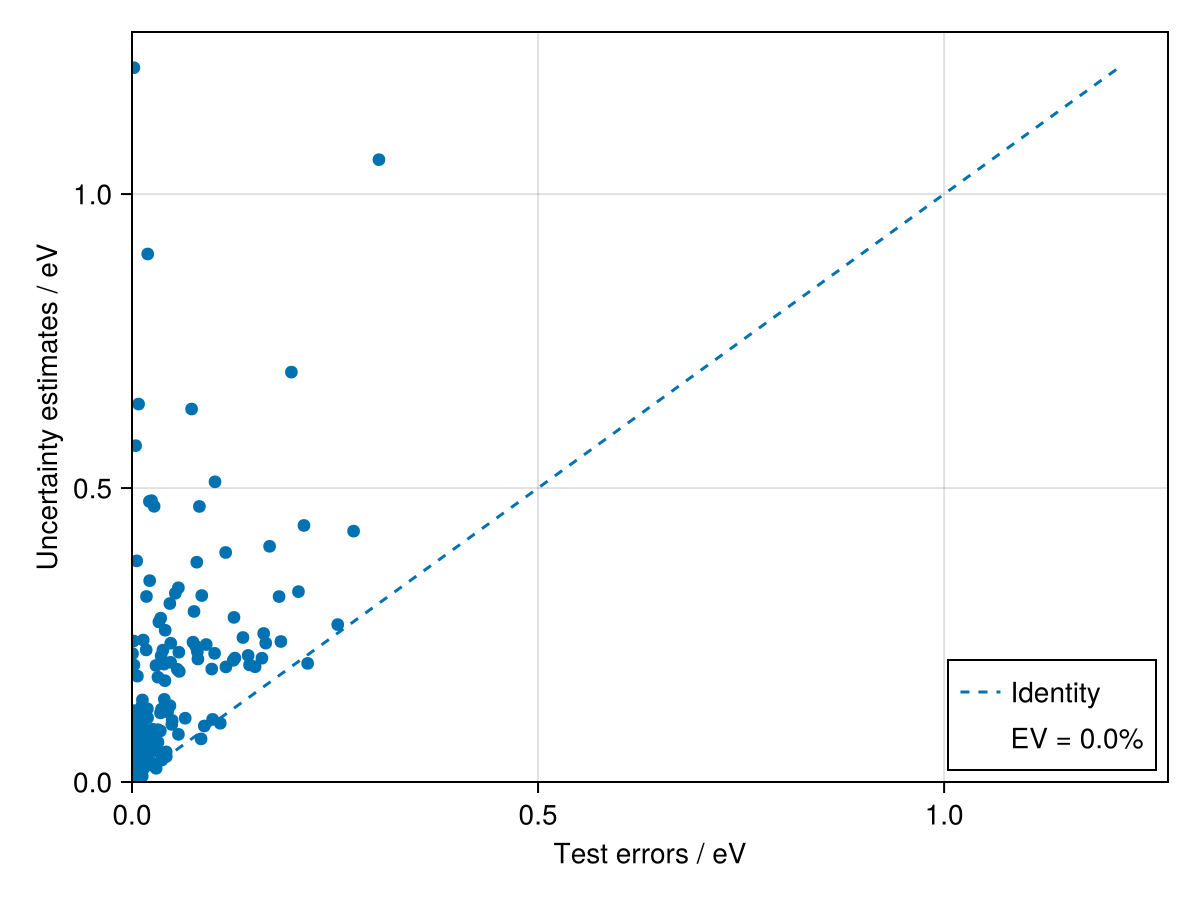

In [ ]:
fig = Figure()
ax  = Axis(fig[1,1], xlabel = "Test errors / eV", ylabel = "Uncertainty estimates / eV")

xdata = abs.(test_E_predictions)
ydata = co_E_range ./ 2

scatter!(ax, xdata, ydata)

max_val = maximum([maximum(xdata), maximum(ydata)])
lines!(ax, [0, max_val], [0, max_val], linestyle = :dash, label = "Identity")
lines!(ax, [NaN], [NaN], label = "EV = $(ev_val)%", color=:white)  # NaN points won't show anything


padding = 0.05 * max_val
xlims!(ax, (0, max_val + padding))
ylims!(ax, (0, max_val + padding))
axislegend(ax, position =  :rb)
save("./high_entropy_pops/test_error_corner_plot_2.5.png", fig)
fig


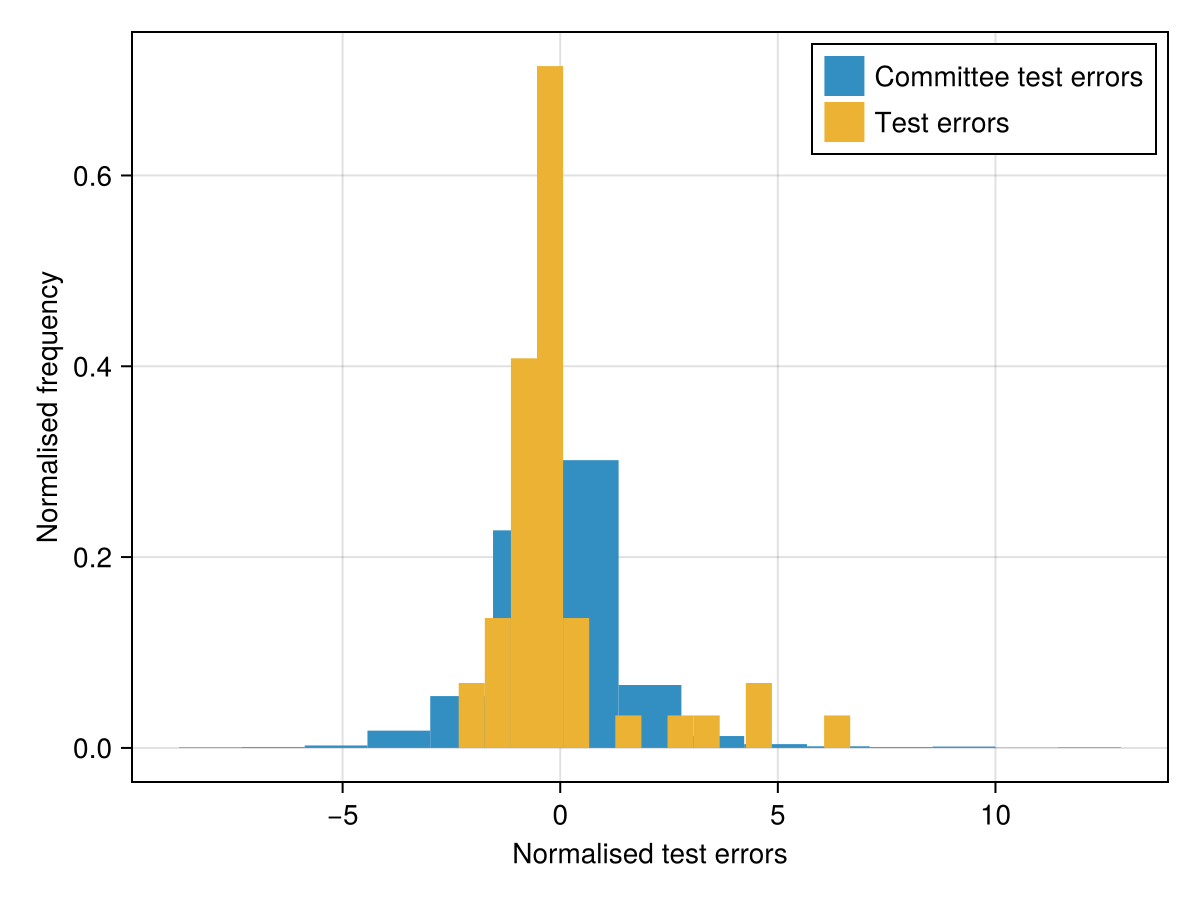

In [16]:
fig = Figure()
ax  = Axis(fig[1,1], xlabel = "Normalised test errors", ylabel = "Normalised frequency")
MAE(x) = sum(abs.(x .- mean(x))) ./ length(x)
test_co_E_predictions = reduce(vcat,test_co_E_predictions)
hist!(ax,  test_co_E_predictions ./ MAE(test_co_E_predictions), normalization = :pdf, label = "Committee test errors", bins = 15)
hist!(ax, test_E_predictions ./ MAE(test_E_predictions), normalization = :pdf, label = "Test errors", bins = 15)
axislegend(ax)
save("./Si_totdeg_$(totaldegree)/test_error_hist_$percentile_clipping.png", fig)
fig

In [90]:
vol_en     = [[17.813109023568057, -163.06663280425], [18.322054995670012, -163.110046112], 
             [18.831000967771949, -163.1415028745], [19.339946939873919, -163.162464704125],
             [19.848892911975845, -163.174242557], [20.3578388840778, -163.177966801875], 
             [20.866784856179741, -163.17463056225], [21.375730828281693, -163.165132595375], 
             [21.884676800383637, -163.150242437875], [22.393622772485578, -163.130671150875], 
             [22.902568744587512, -163.107009425875], [23.411514716689464, -163.079814823625]]
gap_volumes    = [x[1] for x in vol_en]; gap_energies = [x[2] for x in vol_en];

In [91]:
function volume_energy_curve_(;element, lattice_consts_, model, num_in_committee)
    volumes = zeros(length(lattice_consts_))
    energies = zeros(length(lattice_consts_))
    co_energies = zeros(length(lattice_consts_), num_in_committee)
    for i = 1:length(lattice_consts_)
        a = lattice_consts_[i]u"Å"
        bulk_system = bulk(element, cubic = true; a = a)
        vec_1, vec_2, vec_3 = bulk_system.cell.cell_vectors
        volume = dot(vec_1, cross(vec_2, vec_3))
        E, co_E = @committee potential_energy(bulk_system, model)
        energies[i] = ustrip(E)
        co_energies[i, :] = ustrip(co_E)
        volumes[i] = ustrip(volume)
    end
    return volumes, energies, co_energies
end

volume_energy_curve_ (generic function with 1 method)

In [92]:
dif = Int64.(ones(50));

In [93]:
lattice_consts = cbrt.(gap_volumes * 8)
volumes, energies, co_energies = volume_energy_curve_(element = :Si, lattice_consts_ = lattice_consts, model = model, num_in_committee = length(co_ps_vec));

In [94]:
volumes_per_atom     = volumes     ./ 8
energies_per_atom    = energies    ./ 8
co_energies_per_atom = co_energies ./ 8;

In [95]:
function OLS(x::Vector, y::Vector; degree::Int=3)
    n = length(x)
    X = zeros(n, degree + 1)
    for i in 0:degree
        X[:, i+1] .= x .^ i
    end
    coeffs = X \ y
    return coeffs, X
end
function QoI(coeffs)
    c0, c1, c2 = coeffs
    c = c0
    b = c1
    a = c2
    discriminant = b^2 - 4*a*c

    if discriminant < 0
        return NaN, NaN, NaN
    end

    v0 = -b / (2 * a)
    e0 = a*v0^2 + b*v0 + c
    B  = - b
    
    B_quantity = B * u"eV/Å^3"           
    B_GPa = uconvert(u"GPa", B_quantity) |> ustrip
    return v0, e0, B_GPa
end

QoI (generic function with 1 method)

In [96]:
coeffs, X = OLS(volumes_per_atom, energies_per_atom; degree=2)
ace_V0, ace_e0, ace_B     = QoI(coeffs) 

(20.669112898269113, -163.16994665273702, 79.63122071695652)

In [97]:
coeffs, X = OLS(gap_volumes, gap_energies; degree=2)
gap_V0, gap_e0, gap_B_eos     = QoI(coeffs) 

(20.599371554960022, -163.17760822633196, 87.48255726188003)

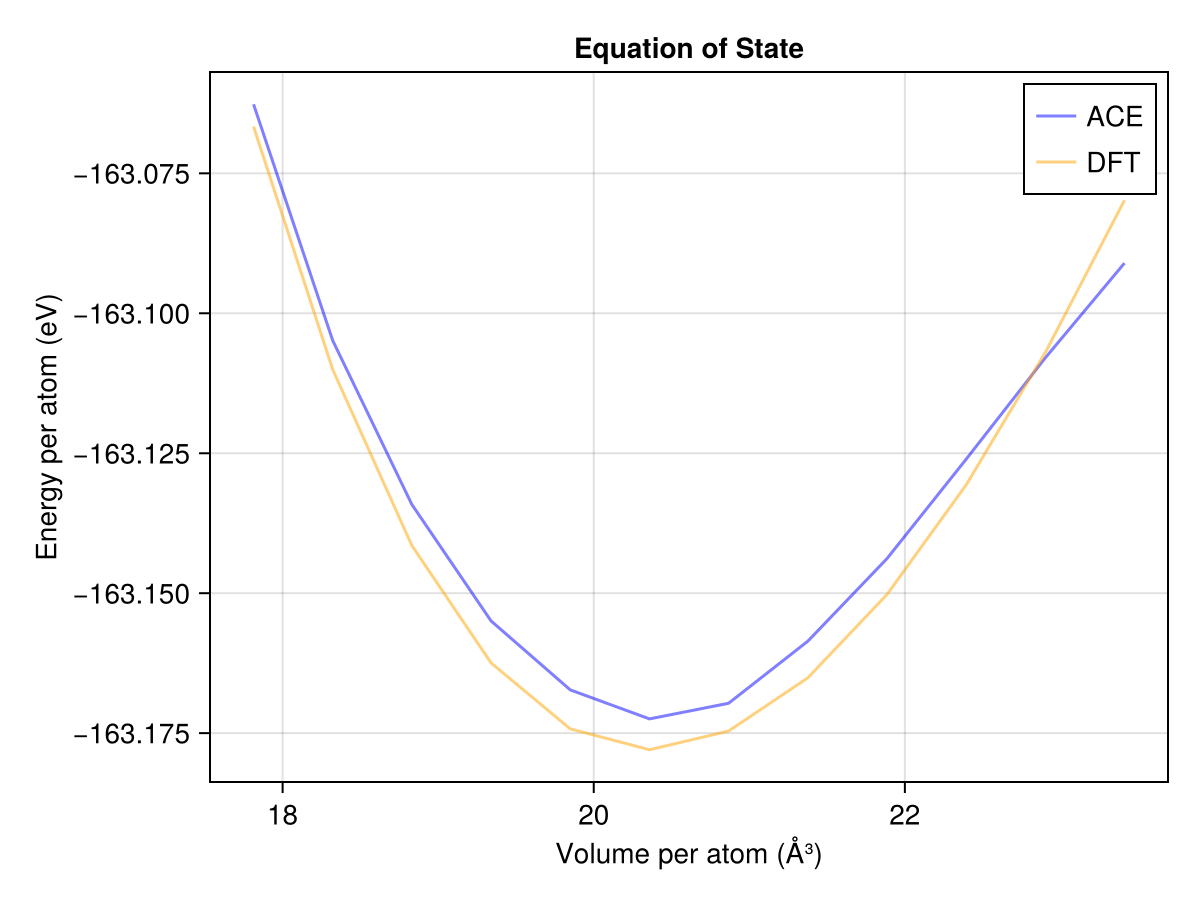

In [98]:
f1 = Figure()
ax1 = Axis(f1[1, 1], xlabel="Volume per atom (Å³)", ylabel="Energy per atom (eV)", title="Equation of State")
lines!(ax1, volumes_per_atom, energies_per_atom, label="ACE", color = :blue, alpha = 0.5)
lines!(ax1, gap_volumes, gap_energies, label="DFT", color = :orange, alpha = 0.5)
axislegend(ax1)
# save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_single_eos_$(totaldegree)_percentile_clipping_$(percentile_clipping).png", f1)
f1

In [100]:
bulk_committee = []
ace_v0_committee=[]
for i = 1:length(co_ps_vec)
    coeffs_i, X_i = OLS(volumes_per_atom, co_energies_per_atom[:,i]; degree=2)
    ace_V0_i, ace_e0_i, ace_B_i     = QoI(coeffs_i)
    push!(bulk_committee, ace_B_i)
    push!(ace_v0_committee, ace_V0_i)
end 

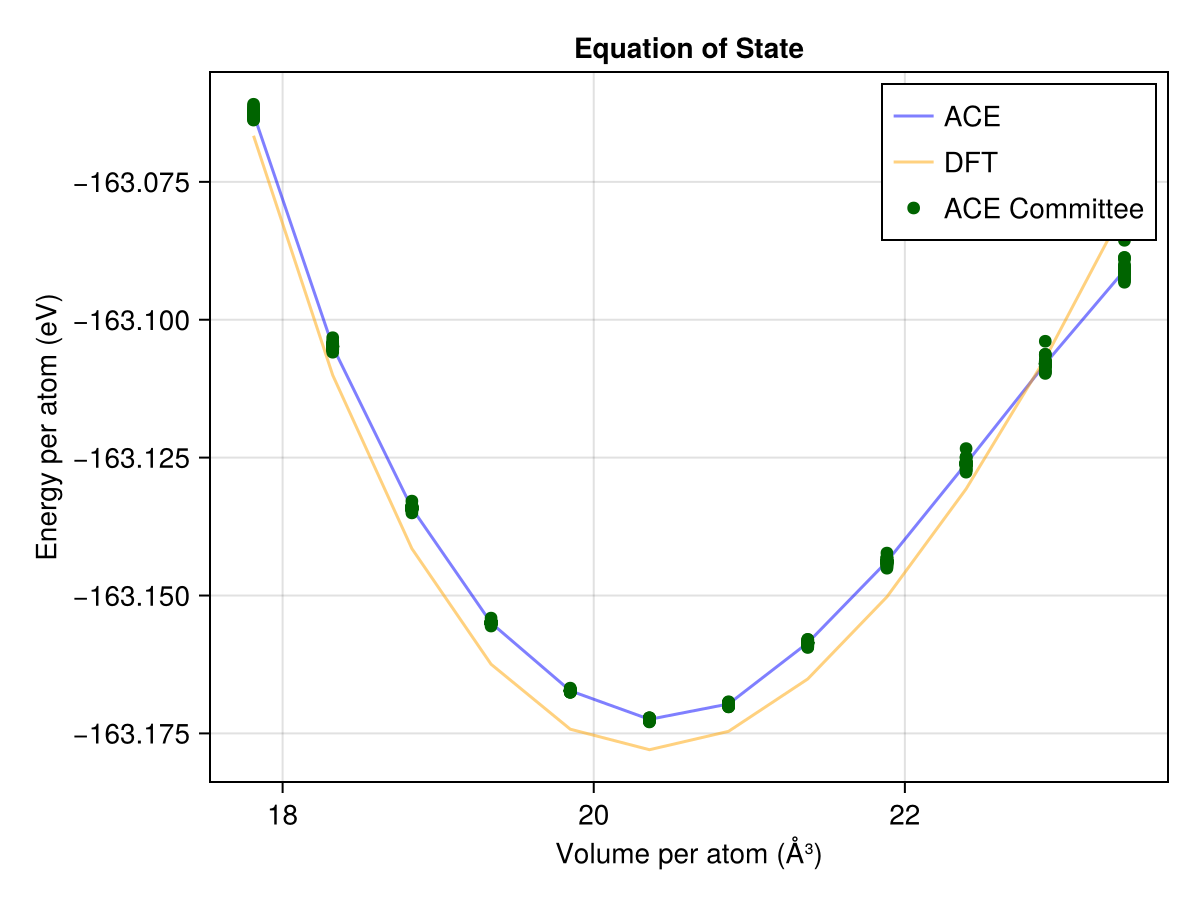

In [101]:
f2 = Figure()
distances_of_coeff_vectors = ones(50)
ax2 = Axis(f2[1, 1], xlabel="Volume per atom (Å³)", ylabel="Energy per atom (eV)", title="Equation of State")
lines!(ax2, volumes_per_atom, energies_per_atom, label="ACE", color = :blue, alpha = 0.5)
lines!(ax2, gap_volumes, gap_energies, label="DFT", color = :orange, alpha = 0.5)
for i=1:length(co_ps_vec[dif])
    if (i == 1)
        scatter!(ax2, volumes_per_atom, co_energies_per_atom[:,i], label="ACE Committee", color = :darkgreen, alpha = distances_of_coeff_vectors[i])
    else
        scatter!(ax2, volumes_per_atom, co_energies_per_atom[:,i], color = :darkgreen, alpha = distances_of_coeff_vectors[i])
    end
end
axislegend(ax2)
# save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_eos_committee_$(totaldegree)_percentile_clipping_$(percentile_clipping).png", f2)
f2

In [103]:
length(bulk_committee)

17739

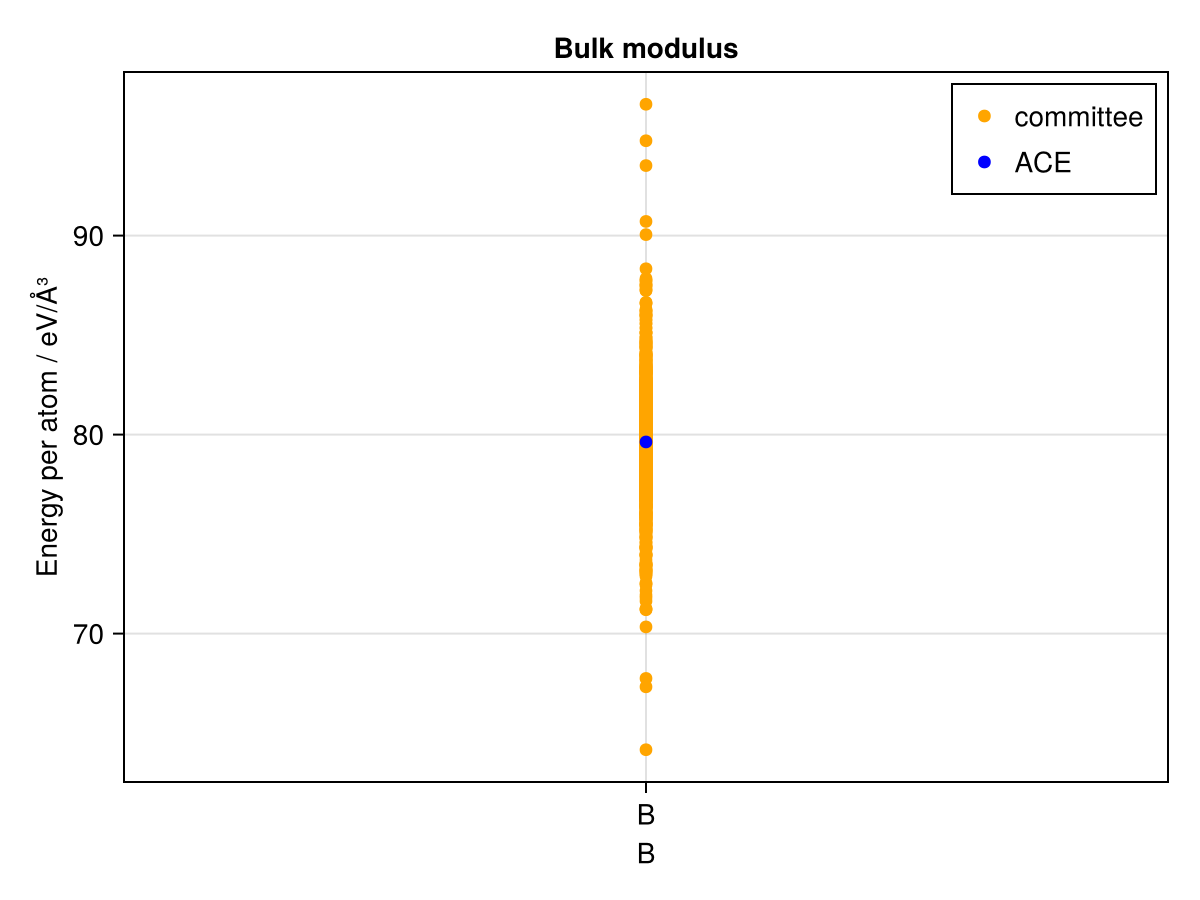

In [105]:
f2 = Figure()
ax2 = Axis(f2[1, 1], xticks=([1],["B"]), xlabel="B", ylabel="Energy per atom / eV/Å³", title="Bulk modulus")
for i=1:length(co_ps_vec)
    if (i == 1)
        scatter!(ax2, 1, bulk_committee[i], label="committee", color = :orange, alpha = 1)
    else
        scatter!(ax2, 1, bulk_committee[i], color = :orange)
    end
end
scatter!(ax2, 1, ace_B, label="ACE", color = :blue, alpha = 1.0)
axislegend(ax2)
# save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_eos_$(totaldegree)_percentile_clipping_$(percentile_clipping).png", f2)
f2

In [27]:
function apply_xy_C12(cell_vectors, δ)
    # Strain tensor for xy shear
    ε = [
        1.0+δ  0.0    0.0
        0.0    1.0-δ  0.0
        0.0    0.0    1.0
    ]

    # Apply strain to each lattice vector
    strained_vectors = Tuple([SVector{3}(ε * vec) for vec in cell_vectors])
    return strained_vectors
end

apply_xy_C12 (generic function with 1 method)

In [28]:
function apply_xy_shear(cell_vectors, δ)
    # Strain tensor for xy shear
    ε = [
        1.0    δ/2    0.0
        δ/2    1.0    0.0
        0.0    0.0   1.0
    ]

    # Apply strain to each lattice vector
    strained_vectors = Tuple([SVector{3}(ε * vec) for vec in cell_vectors])
    return strained_vectors
end

apply_xy_shear (generic function with 1 method)

In [29]:
function apply_x_uniaxial(cell_vectors, δ)
    # Strain tensor for xy shear
    ε = [
        1.0+δ  0.0    0.0
        0.0    1.0    0.0
        0.0    0.0    1.0
    ]

    # Apply strain to each lattice vector
    strained_vectors = Tuple([SVector{3}(ε * vec) for vec in cell_vectors])
    return strained_vectors
end

apply_x_uniaxial (generic function with 1 method)

In [30]:
function make_Si_unit_cell(lattice)
    a = 5.431u"Å"
    
    # Diamond cubic basis positions (in fractional coords)
    frac_basis = [
        SVector(0.0, 0.0, 0.0),
        SVector(0.25, 0.25, 0.25),
        SVector(0.5, 0.5, 0.0),
        SVector(0.75, 0.75, 0.25),
        SVector(0.5, 0.0, 0.5),
        SVector(0.75, 0.25, 0.75),
        SVector(0.0, 0.5, 0.5),
        SVector(0.25, 0.75, 0.75),
    ]
    
    # Convert to cartesian coordinates
    cartesian_positions = [lattice[1] * f[1] + lattice[2] * f[2] + lattice[3] * f[3] for f in frac_basis]
    atoms = [Atom(:Si, pos) for pos in cartesian_positions]
    
    # Construct the periodic system
    unit_cell = periodic_system(atoms, lattice; pbc=NTuple{3,Bool}((true, true, true)))
    return unit_cell
end

make_Si_unit_cell (generic function with 1 method)

In [31]:
GC.gc()
function stress(model, d, deformation)
    a = 5.4610215037046075
    Ss = []
    Vs = []
    cell_vectors = ([1.0, 0.0, 0.0].*(a*u"Å"), [0.0, 1.0, 0.0].*(a*u"Å"), [0.0, 0.0, 1.0].*(a*u"Å"))
    for (i, delta) in enumerate(d)
        box = deformation(cell_vectors, delta)
        global Si_cell_    = make_Si_unit_cell(box)
        Si_cell_, _ = GeomOpt.minimise(Si_cell_, model;  verbose = 0);
        V           = dot(Si_cell_.cell.cell_vectors[1], cross(Si_cell_.cell.cell_vectors[2], Si_cell_.cell.cell_vectors[3]))
        S           = virial(Si_cell_, model) ./ V
        push!(Ss, S)
        push!(Vs, ustrip(V))
    end
    return Ss
end

stress (generic function with 1 method)

In [32]:
# === Ordinary Least Squares polynomial fit ===
function OLS(x::Vector, y::Vector; degree::Int=2)
    n = length(x)
    X = zeros(n, degree + 1)
    for i in 0:degree
        X[:, i+1] .= x .^ i
    end
    coeffs = X \ y
    return coeffs, X
end

function design(x::Vector; degree::Int=2)
    n = length(x)
    X = zeros(n, degree + 1)
    for i in 0:degree
        X[:, i+1] .= x .^ i
    end
    return X
end

design (generic function with 1 method)

In [33]:
leverage_percentile = "_dia_with_test_set_aside_total_degree_$(totaldegree)_percentile_clipping_$(percentile_clipping)_leverage_percentile_$(leverage_percentile)"

"_dia_with_test_set_aside_total_degree_10_percentile_clipping_10.0_leverage_percentile_0.5"

74.49103683461719 GPa


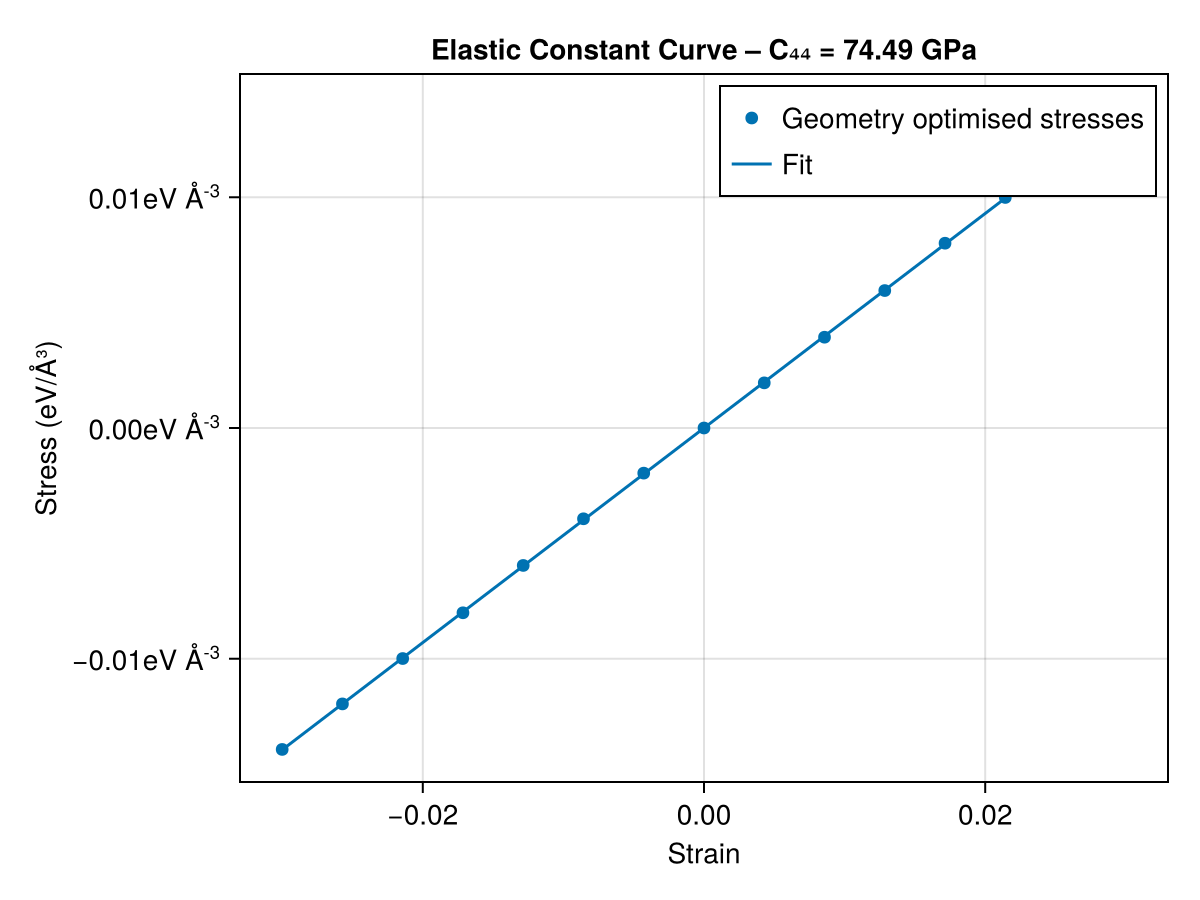

In [34]:
d = LinRange(-0.03, 0.03, 15)

# C44
f_C44 = Figure()
Ss = stress(model, d, apply_xy_shear)
S12 = [-S[1,2] for S in Ss]
d = Vector{Float64}(d)
S12_unitless = ustrip(S12)
coeffs, X = OLS(d, Vector{Float64}(S12_unitless); degree=1)
d_pred = Vector(LinRange(minimum(d), maximum(d), 20))
X_pred = design(d_pred; degree=1)
C44 = coeffs[2] * 160.2176621

ax_C44 = Axis(
    f_C44[1, 1],
    xlabel = "Strain",
    ylabel = "Stress (eV/Å³)",
    title = "Elastic Constant Curve – C₄₄ = $(round(C44, digits=2)) GPa"
)
plot!(ax_C44, d, S12; label = "Geometry optimised stresses")
lines!(ax_C44, d_pred, (X_pred * coeffs) .* u"eV/Å^3", label = "Fit")
axislegend(ax_C44)
#save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_$(leverage_percentile)_C_44.png", f_C44)
println(C44, " GPa")
f_C44

Quantity{Float64, 𝐌 𝐋^-1 𝐓^-2, Unitful.FreeUnits{(Å^-3, eV), 𝐌 𝐋^-1 𝐓^-2, nothing}}[0.02811567688457903 eV Å^-3 -6.174067887064218e-19 eV Å^-3 -3.676106227755193e-18 eV Å^-3; 4.661536323442109e-18 eV Å^-3 0.013029552905991462 eV Å^-3 -2.288002978006554e-19 eV Å^-3; -1.0391323093569018e-18 eV Å^-3 -7.202284945526557e-18 eV Å^-3 0.01302955290598778 eV Å^-3]
145.0957380813528 GPa


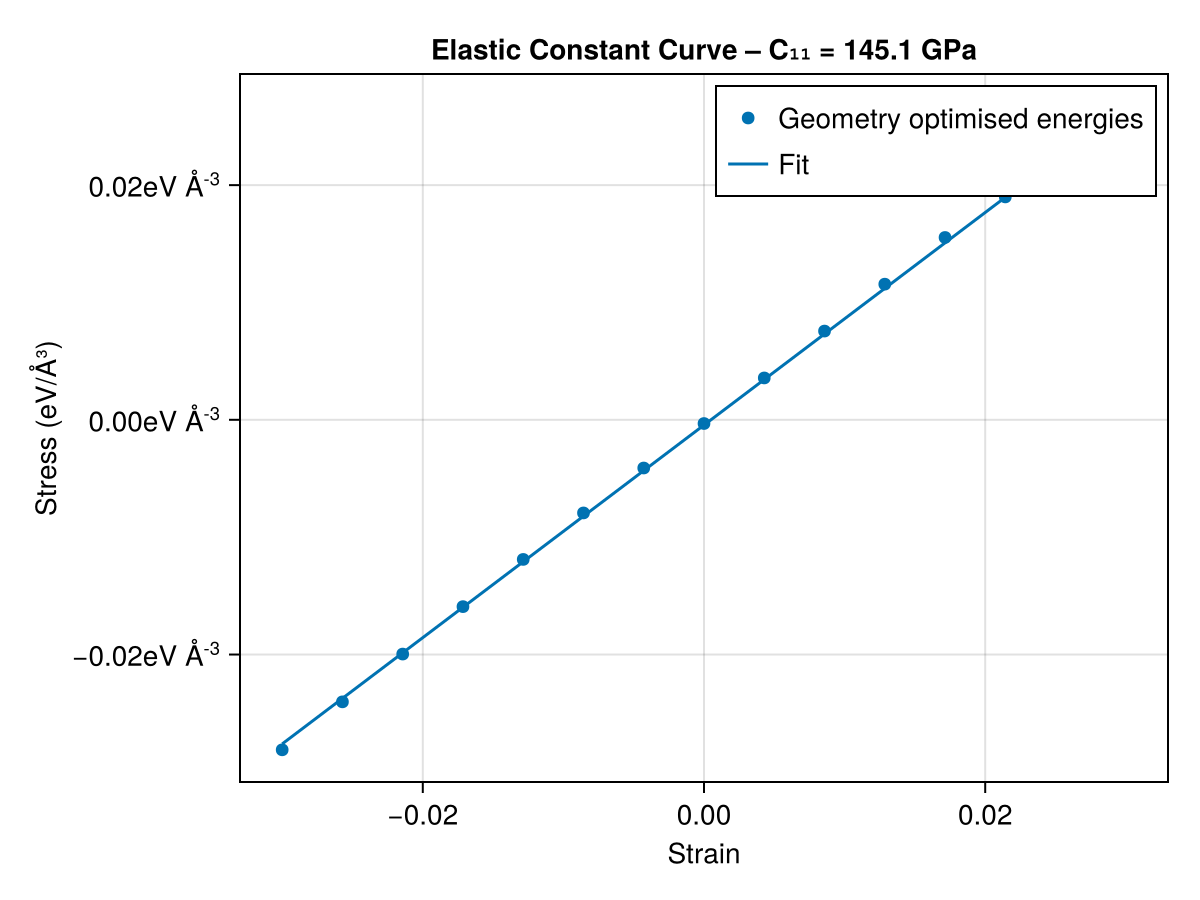

In [35]:
# C11
f_C11 = Figure()
Ss = stress(model, d, apply_x_uniaxial)
println(Ss[1])
S11 = [-S[1,1] for S in Ss]
d = Vector{Float64}(d)
S11_unitless = ustrip(S11)
coeffs, X = OLS(d, Vector{Float64}(S11_unitless); degree=1)
d_pred = Vector(LinRange(minimum(d), maximum(d), 20))
X_pred = design(d_pred; degree=1)
C11 = coeffs[2] * 160.2176621

ax_C11 = Axis(
    f_C11[1, 1],
    xlabel = "Strain",
    ylabel = "Stress (eV/Å³)",
    title = "Elastic Constant Curve – C₁₁ = $(round(C11, digits=2)) GPa"
)
plot!(ax_C11, d, S11; label = "Geometry optimised energies")
lines!(ax_C11, d_pred, (X_pred * coeffs) .* u"eV/Å^3", label = "Fit")
axislegend(ax_C11)
#save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_$(leverage_percentile)_C_11.png", f_C11)
println(C11, " GPa")
f_C11


61.00661736376942 GPa


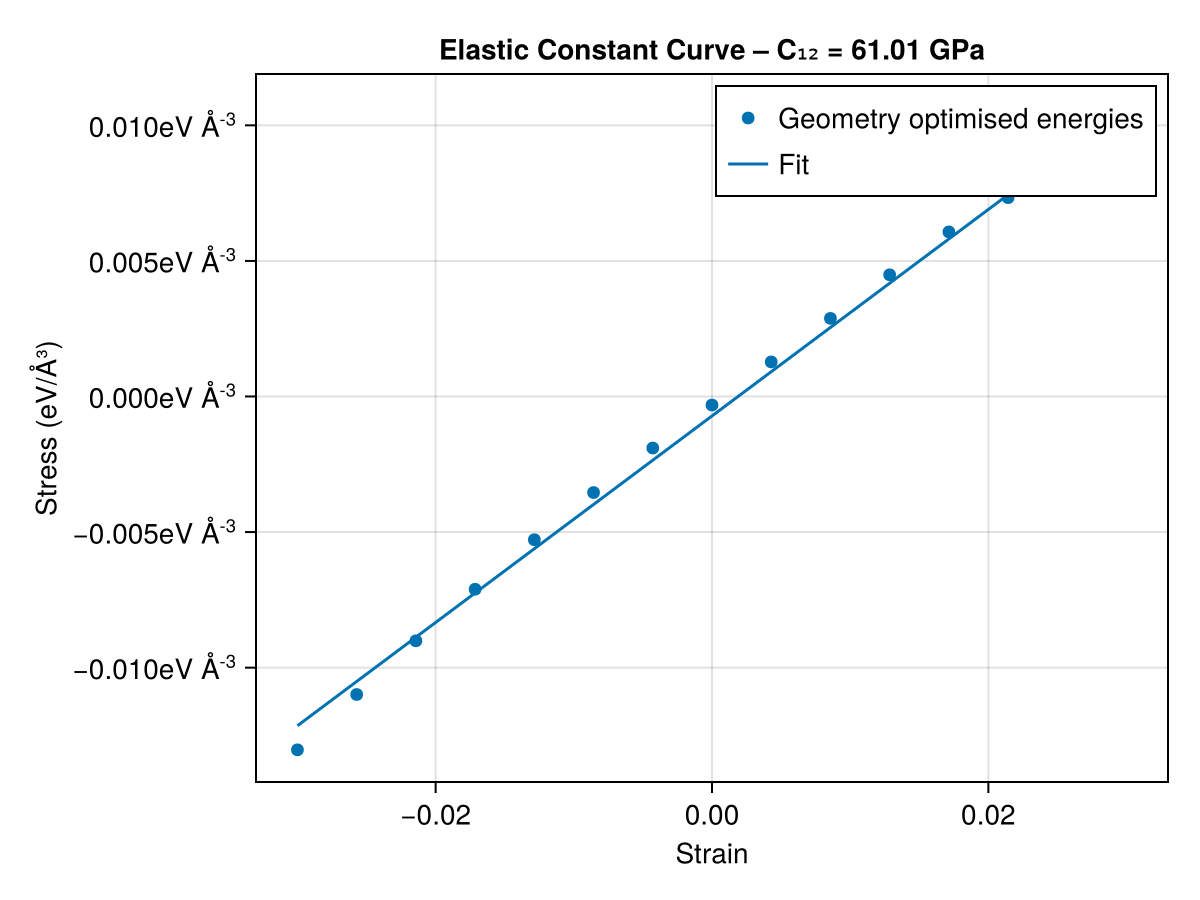

In [36]:
# C12
f_C12 = Figure()
S12 = [-S[2,2] for S in Ss]
d = Vector{Float64}(d)
S12_unitless = ustrip(S12)
coeffs, X = OLS(d, Vector{Float64}(S12_unitless); degree=1)
d_pred = Vector(LinRange(minimum(d), maximum(d), 20))
X_pred = design(d_pred; degree=1)
C12 = coeffs[2] * 160.2176621

ax_C12 = Axis(
    f_C12[1, 1],
    xlabel = "Strain",
    ylabel = "Stress (eV/Å³)",
    title = "Elastic Constant Curve – C₁₂ = $(round(C12, digits=2)) GPa"
)
plot!(ax_C12, d, S12; label = "Geometry optimised energies")
lines!(ax_C12, d_pred, (X_pred * coeffs) .* u"eV/Å^3", label = "Fit")
axislegend(ax_C12)
#save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_$(leverage_percentile)_C_12.png", f_C12)
println(C12, " GPa")
f_C12

In [37]:
model_outline = deepcopy(model);

In [38]:
C11_co = []
C12_co = []
C44_co = []
for i = 1:length(co_ps_vec[dif])
    model_ind = deepcopy(model_outline)
    ACEpotentials.Models.set_linear_parameters!(model_ind, co_ps_vec[i]);
    Ss1 = stress(model_ind, d, apply_x_uniaxial)
    S11 = [-S[1,1] for S in Ss1]
    S12 = [-S[2,2] for S in Ss1]
    S12_unitless = ustrip(S12)
    S11_unitless = ustrip(S11)
    coeffs_11, X = OLS(d, Vector{Float64}(S11_unitless); degree=1)
    append!(C11_co, coeffs_11[2]*160.2176621)
    coeffs_12, X = OLS(d, Vector{Float64}(S12_unitless); degree=1)
    append!(C12_co, coeffs_12[2]*160.2176621)
    Ss4 = stress(model_ind, d, apply_xy_shear)
    S44 = [-S[1,2] for S in Ss4]
    S44_unitless = ustrip(S44)
    coeffs_44, X = OLS(d, Vector{Float64}(S44_unitless); degree=1)
    append!(C44_co, coeffs_44[2]*160.2176621)
end

In [39]:
gap_B = 88.596696666666602
gap_C12 = 56.25008999999995
gap_C11 = 153.28990999999988
gap_C44 = 72.176929999999999
gap_B_voigt = 1 / 3 .* (gap_C11 .+ 2 .* gap_C12);
dft_ = [gap_C11, gap_C12, gap_C44, gap_B, gap_B_voigt]

5-element Vector{Float64}:
 153.28990999999988
  56.25008999999995
  72.17693
  88.5966966666666
  88.59669666666659

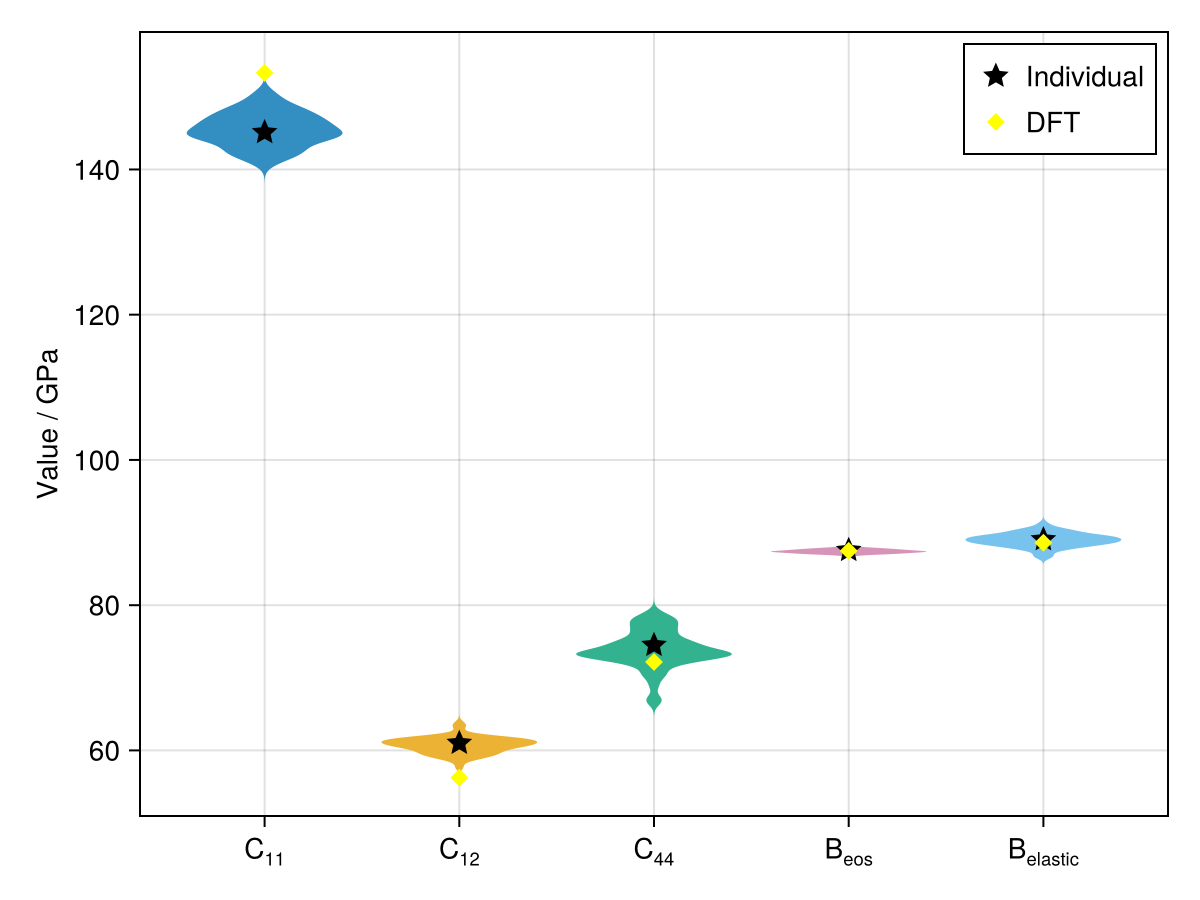

In [40]:
B_voigt = 1 / 3 * (C11 + 2 * C12); B_voigt_co = 1 / 3 .* (C11_co .+ 2 .* C12_co);
gap_B = 88.596696666666602
gap_C12 = 56.25008999999995
gap_C11 = 153.28990999999988
gap_C44 = 72.176929999999999
gap_B_voigt = 1 / 3 .* (gap_C11 .+ 2 .* gap_C12);
# X-axis setup
labels = [
    rich("C", subscript("11")),
    rich("C", subscript("12")),
    rich("C", subscript("44")),
    rich("B", subscript("eos")),
    rich("B", subscript("elastic"))
]
x_pos = 1:5

fig = Figure()
ax = Axis(fig[1, 1]; xticks=(x_pos, labels), ylabel="Value / GPa")

# Committee scatter plots
violin!(fill(x_pos[1], length(C11_co)), C11_co)
violin!(fill(x_pos[2], length(C12_co)), C12_co)
violin!(fill(x_pos[3], length(C44_co)), C44_co)
violin!(fill(x_pos[4], length(bulk_committee)), bulk_committee)
violin!(fill(x_pos[5], length(B_voigt_co)), B_voigt_co)
# Individual predictions
scatter!(x_pos, [C11, C12, C44, ace_B, B_voigt], marker=:star5, color=:black, markersize=15, label="Individual")

# DFT reference values (gap_*), plotted as diamonds
scatter!(x_pos, [gap_C11, gap_C12, gap_C44, gap_B_eos, gap_B_voigt], marker=:diamond, color=:yellow, markersize=10, label="DFT")


axislegend(ax, position=:rt)
#save("./Si_totdeg_$(totaldegree)/violin_QoIs.png", fig)
fig

In [43]:
writedlm("./Si_totdeg_20/co_coeffs.csv", co_ps_vec, ',')

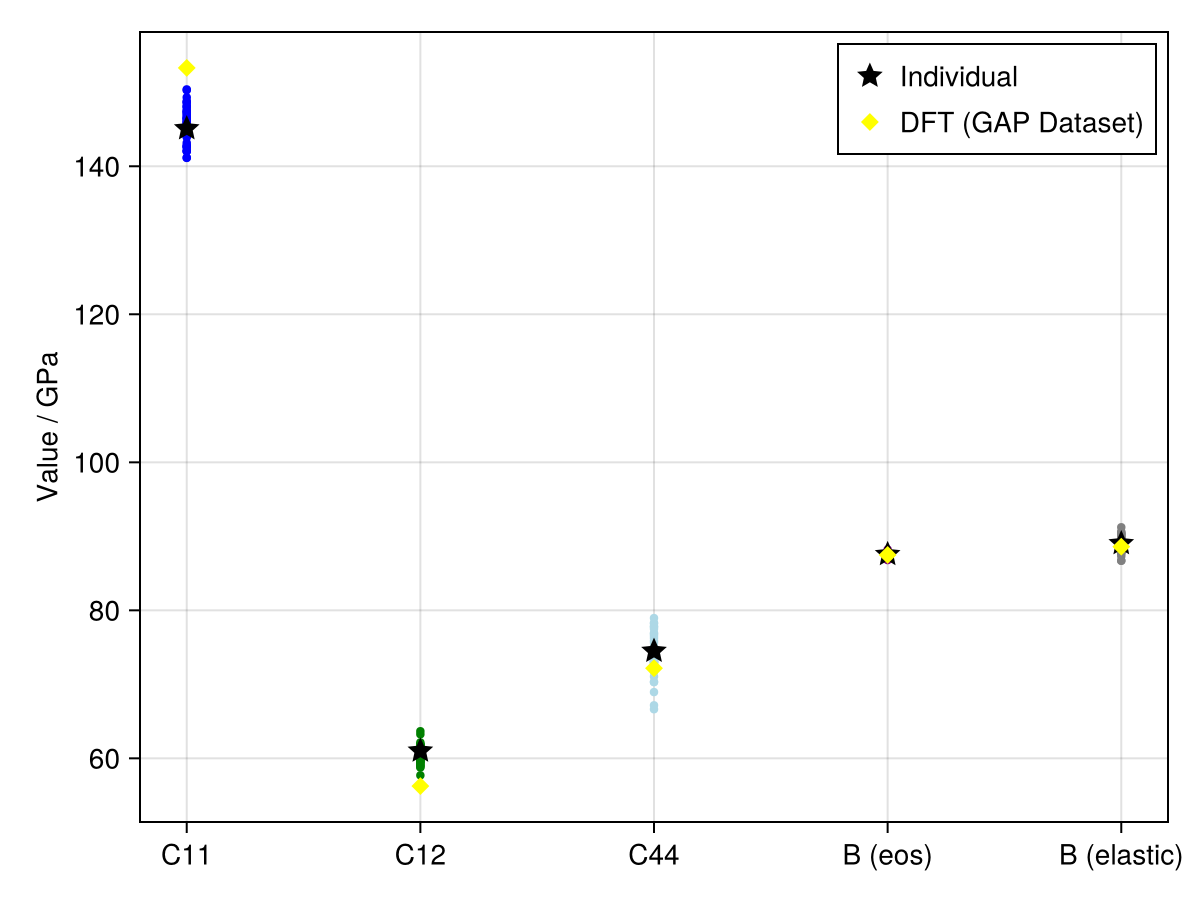

In [41]:
B_voigt = 1 / 3 * (C11 + 2 * C12); B_voigt_co = 1 / 3 .* (C11_co .+ 2 .* C12_co);
gap_B = 88.596696666666602
gap_C12 = 56.25008999999995
gap_C11 = 153.28990999999988
gap_C44 = 72.176929999999999
gap_B_voigt = 1 / 3 .* (gap_C11 .+ 2 .* gap_C12);
# X-axis setup
labels = ["C11", "C12", "C44", "B (eos)", "B (elastic)"]
x_pos = 1:5

fig = Figure()
ax = Axis(fig[1, 1]; xticks=(x_pos, labels), ylabel="Value / GPa")

# Committee scatter plots
for i = 1:50
    scatter!(ax, x_pos[1], C11_co[i], color=:blue, markersize=6, alpha = distances_of_coeff_vectors[i])
    scatter!(ax, x_pos[2], C12_co[i], color=:green, markersize=6, alpha = distances_of_coeff_vectors[i])
    scatter!(ax, x_pos[3], C44_co[i], color=:lightblue, markersize=6, alpha = distances_of_coeff_vectors[i])
    scatter!(ax, x_pos[4], bulk_committee[i], color=:purple, markersize=6, alpha = distances_of_coeff_vectors[i])
    scatter!(ax, x_pos[5], B_voigt_co[i], color=:gray, markersize=6, alpha = distances_of_coeff_vectors[i])
end
# Individual predictions
scatter!(x_pos, [C11, C12, C44, ace_B, B_voigt], marker=:star5, color=:black, markersize=15, label="Individual")

# DFT reference values (gap_*), plotted as diamonds
scatter!(x_pos, [gap_C11, gap_C12, gap_C44, gap_B_eos, gap_B_voigt], marker=:diamond, color=:yellow, markersize=10, label="DFT (GAP Dataset)")



axislegend(ax, position=:rt)
#save("./Si_totdeg_$(totaldegree)/QoIs_leverage_$(lev)_clipping_$(percentile_clipping)_$leverage_percentile.png", fig)
fig

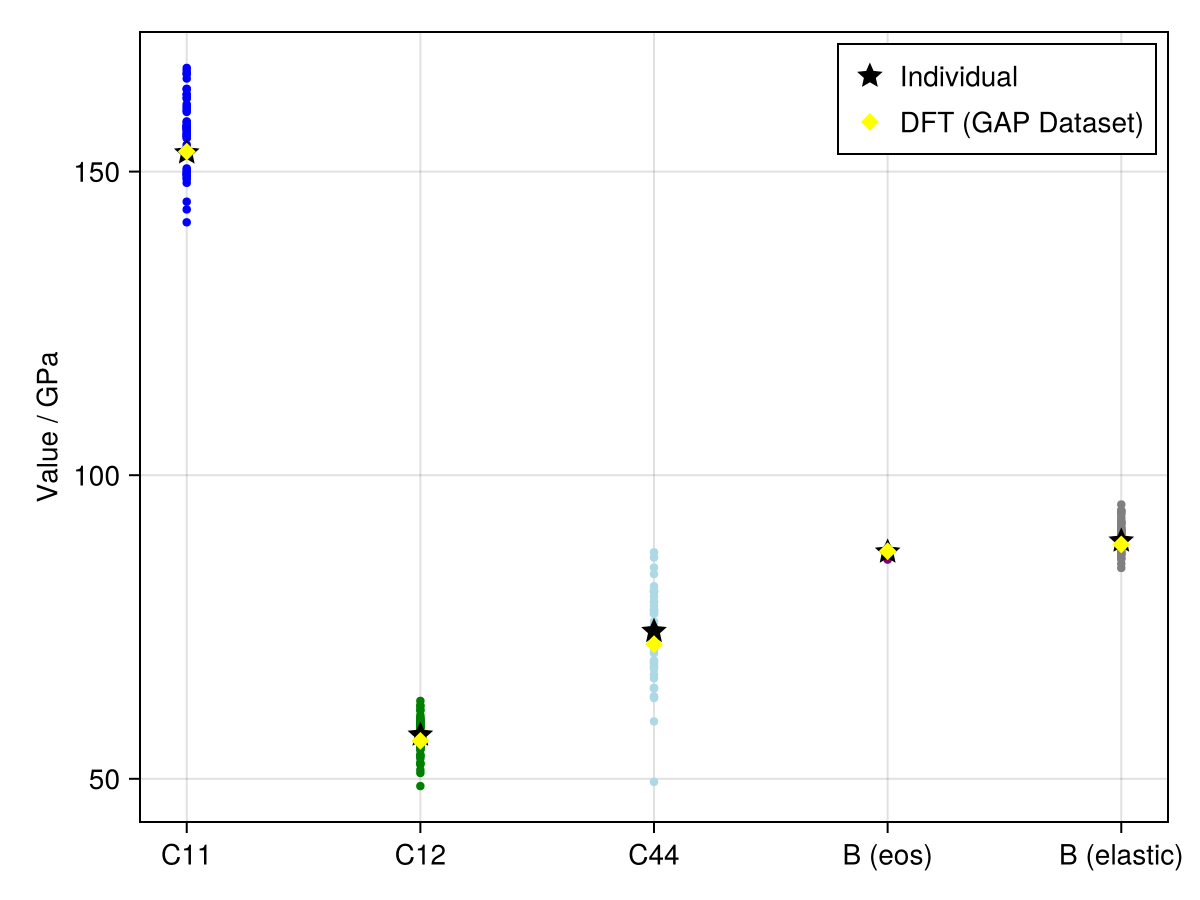

In [40]:
B_voigt = 1 / 3 * (C11 + 2 * C12); B_voigt_co = 1 / 3 .* (C11_co .+ 2 .* C12_co);
gap_B = 88.596696666666602
gap_C12 = 56.25008999999995
gap_C11 = 153.28990999999988
gap_C44 = 72.176929999999999
gap_B_voigt = 1 / 3 .* (gap_C11 .+ 2 .* gap_C12);
# X-axis setup
labels = ["C11", "C12", "C44", "B (eos)", "B (elastic)"]
x_pos = 1:5

fig = Figure()
ax = Axis(fig[1, 1]; xticks=(x_pos, labels), ylabel="Value / GPa")

# Committee scatter plots
scatter!(fill(x_pos[1], length(C11_co)), C11_co, color=:blue, markersize=6)
scatter!(fill(x_pos[2], length(C11_co)), C12_co, color=:green, markersize=6)
scatter!(fill(x_pos[3], length(C11_co)), C44_co, color=:lightblue, markersize=6)
scatter!(fill(x_pos[4], length(C11_co)), bulk_committee, color=:purple, markersize=6)
scatter!(fill(x_pos[5], length(C11_co)), B_voigt_co, color=:gray, markersize=6)

# Individual predictions
scatter!(x_pos, [C11, C12, C44, ace_B, B_voigt], marker=:star5, color=:black, markersize=15, label="Individual")

# DFT reference values (gap_*), plotted as diamonds
scatter!(x_pos, [gap_C11, gap_C12, gap_C44, gap_B_eos, gap_B_voigt], marker=:diamond, color=:yellow, markersize=10, label="DFT (GAP Dataset)")



axislegend(ax, position=:rt)
#save("./Si_totdeg_$(totaldegree)/QoIs_leverage_$(lev)_clipping_$(percentile_clipping)_$leverage_percentile.png", fig)
fig

In [43]:
percentile_clipping

0.5

In [41]:
qoi_s = [C11, C12, C44, ace_B, B_voigt, C11_co, C12_co, C44_co, bulk_committee, B_voigt_co]
using DelimitedFiles
writedlm("./Si_totdeg_$(totaldegree)/Si_qoi_s_$(leverage_percentile)_$percentile_clipping.csv", qoi_s, ',');

In [27]:
for totaldegree=6:14
    model, Ap, Y, P = read_model(totaldegree);
    params = P\(Ap\Y);
    percentile_clipping  = 0.0
    ev_val_              = 1.0
    test_violations_     = 1.0
    ev_val               = 0.0
    test_violations      = 0.0
    while (ev_val_ >= ev_val && test_violations_ >= test_violations)
        ev_val, test_violations = POPS_percentile_clipping_calculator(params, model, test, percentile_clipping)
        println(ev_val, " ", test_violations, " ", percentile_clipping)
        global percentile_clipping += 0.5
    end
    percentile_clipping -= 1.0
    open("./Si_totdeg_$(totaldegree)/optimal_pc_$(percentile_clipping).txt", "w") do io
        write(io, percentile_clipping)
    end
    leverage_percentile = 0.5; lev = 0.5;
    corr_, _ = corrections(Ap, Y, P; leverage_percentile = leverage_percentile, coeffs = nothing);
    corr_ = (P \ corr_')';
    hypercube_support, hypercube_bounds = hypercube(corr_; percentile_clipping = percentile_clipping);
    
    committee, misspec_sigma = sample_hypercube(hypercube_support, hypercube_bounds, params);
    co_coeffs = committee
    co_ps_vec = [ co_coeffs[:,i] for i in 1:size(co_coeffs,2) ];
    set_committee!(model, co_ps_vec);
    test_E = []
    test_E_predictions = []
    test_co_E_predictions = []
    ev_val = counter = 0  
    co_E_range = []
    for (i, at) in enumerate(test)
        energy = at[:dft_energy]
        push!(test_E, energy)
        E, co_E= @committee potential_energy(at, model)
        push!(test_E_predictions, ustrip(E) - energy)
        push!(test_co_E_predictions, ustrip.(co_E) .- ustrip(E))
        push!(co_E_range, abs(maximum(ustrip.(co_E)) - minimum(ustrip.(co_E))))
        if (ustrip(E) > minimum(ustrip.(co_E)) && ustrip(E) < maximum(ustrip.(co_E)))
            counter += 1
        else
            ev_val +=  1
            counter += 1
        end
    end
    ev_val /= counter
    ev_val *= 100
    fig = Figure()
    ax  = Axis(fig[1,1], xlabel = "Test errors / eV", ylabel = "Uncertainty estimates / eV", title = "Calibration plot | total degree = $totaldegree | percentile clipping = $(percentile_clipping)%")
    
    xdata = abs.(test_E_predictions)
    ydata = co_E_range ./ 2
    
    scatter!(ax, xdata, ydata)
    
    max_val = maximum([maximum(xdata), maximum(ydata)])
    lines!(ax, [0, max_val], [0, max_val], linestyle = :dash, label = "Identity")
    lines!(ax, [NaN], [NaN], label = "EV = $(ev_val)%", color=:white)  # NaN points won't show anything
    
    padding = 0.05 * max_val
    xlims!(ax, (0, max_val + padding))
    ylims!(ax, (0, max_val + padding))
    axislegend(ax, position =  :rb)
    save("./Si_totdeg_$(totaldegree)/test_error_corner_plot_$percentile_clipping.png", fig)
    
    fig = Figure()
    ax  = Axis(fig[1,1], xlabel = "Normalised test errors", ylabel = "Normalised frequency", title = "Test errors of model predictions | total degree = $totaldegree | percentile clipping = $(percentile_clipping)%")
    MAE(x) = sum(abs.(x .- mean(x))) ./ length(x)
    test_co_E_predictions = reduce(vcat,test_co_E_predictions)
    hist!(ax,  test_co_E_predictions ./ MAE(test_co_E_predictions), normalization = :pdf, label = "Committee test errors", bins = 15)
    hist!(ax, test_E_predictions ./ MAE(test_E_predictions), normalization = :pdf, label = "Test errors", bins = 15)
    axislegend(ax)
    save("./Si_totdeg_$(totaldegree)/test_error_hist_$percentile_clipping.png", fig)

    vol_en     = [[17.813109023568057, -163.06663280425], [18.322054995670012, -163.110046112], 
                 [18.831000967771949, -163.1415028745], [19.339946939873919, -163.162464704125],
                 [19.848892911975845, -163.174242557], [20.3578388840778, -163.177966801875], 
                 [20.866784856179741, -163.17463056225], [21.375730828281693, -163.165132595375], 
                 [21.884676800383637, -163.150242437875], [22.393622772485578, -163.130671150875], 
                 [22.902568744587512, -163.107009425875], [23.411514716689464, -163.079814823625]]
    gap_volumes    = [x[1] for x in vol_en]; gap_energies = [x[2] for x in vol_en];
    lattice_consts = cbrt.(gap_volumes * 8)
    volumes, energies, co_energies = volume_energy_curve_(element = :Si, lattice_consts_ = lattice_consts, model = model, num_in_committee = 50);

    volumes_per_atom     = volumes     ./ 8
    energies_per_atom    = energies    ./ 8
    co_energies_per_atom = co_energies ./ 8;

    coeffs, X = OLS(volumes_per_atom, energies_per_atom; degree=2)
    ace_V0, ace_e0, ace_B     = QoI(coeffs) 
    coeffs, X = OLS(gap_volumes, gap_energies; degree=2)
    gap_V0, gap_e0, gap_B_eos     = QoI(coeffs) 
    f1 = Figure()
    ax1 = Axis(f1[1, 1], xlabel="Volume per atom (Å³)", ylabel="Energy per atom (eV)", title="Equation of State")
    lines!(ax1, volumes_per_atom, energies_per_atom, label="ACE", color = :blue, alpha = 0.5)
    lines!(ax1, gap_volumes, gap_energies, label="DFT", color = :orange, alpha = 0.5)
    axislegend(ax1)
    save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_single_eos_$(totaldegree)_percentile_clipping_$(percentile_clipping).png", f1)

    bulk_committee = []
    ace_v0_committee=[]
    for i = 1:50
        coeffs_i, X_i = OLS(volumes_per_atom, co_energies_per_atom[:,i]; degree=2)
        ace_V0_i, ace_e0_i, ace_B_i     = QoI(coeffs_i)
        push!(bulk_committee, ace_B_i)
        push!(ace_v0_committee, ace_V0_i)
    end
    f2 = Figure()
    ax2 = Axis(f2[1, 1], xlabel="Volume per atom (Å³)", ylabel="Energy per atom (eV)", title="Equation of State")
    lines!(ax2, volumes_per_atom, energies_per_atom, label="ACE", color = :blue, alpha = 0.5)
    lines!(ax2, gap_volumes, gap_energies, label="DFT", color = :orange, alpha = 0.5)
    for i=1:50
        if (i == 1)
            scatter!(ax2, volumes_per_atom, co_energies_per_atom[:,i], label="ACE Committee", color = :darkgreen, alpha = 0.25)
        else
            scatter!(ax2, volumes_per_atom, co_energies_per_atom[:,i], color = :darkgreen, alpha = 0.25)
        end
    end
    axislegend(ax2)
    save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_eos_committee_$(totaldegree)_percentile_clipping_$(percentile_clipping).png", f2)

    f2 = Figure()
    ax2 = Axis(f2[1, 1], xticks=([1],["B"]), xlabel="B", ylabel="Energy per atom / eV/Å³", title="Bulk modulus")
    
    scatter!(ax2, ones(length(bulk_committee)), bulk_committee, label="committee", color = :orange, alpha = 0.5)
    scatter!(ax2, 1, ace_B, label="ACE", color = :blue, alpha = 0.5)
    axislegend(ax2)
    save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_eos_$(totaldegree)_percentile_clipping_$(percentile_clipping).png", f2)

    leverage_percentile = "_dia_with_test_set_aside_total_degree_$(totaldegree)_percentile_clipping_$(percentile_clipping)_leverage_percentile_$(leverage_percentile)"
    d = LinRange(-0.03, 0.03, 15)
    
    # C44
    f_C44 = Figure()
    Ss = stress(model, d, apply_xy_shear)
    S12 = [-S[1,2] for S in Ss]
    d = Vector{Float64}(d)
    S12_unitless = ustrip(S12)
    coeffs, X = OLS(d, Vector{Float64}(S12_unitless); degree=3)
    d_pred = Vector(LinRange(minimum(d), maximum(d), 20))
    X_pred = design(d_pred; degree=3)
    C44 = coeffs[2] * 160.2176621
    
    ax_C44 = Axis(
        f_C44[1, 1],
        xlabel = "Strain",
        ylabel = "Stress (eV/Å³)",
        title = "Elastic Constant Curve – C₄₄ = $(round(C44, digits=2)) GPa"
    )
    plot!(ax_C44, d, S12; label = "Geometry optimised stresses")
    lines!(ax_C44, d_pred, (X_pred * coeffs) .* u"eV/Å^3", label = "Fit")
    axislegend(ax_C44)
    save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_$(leverage_percentile)_C_44.png", f_C44)
    println(C44, " GPa")

    # C11
    f_C11 = Figure()
    Ss = stress(model, d, apply_x_uniaxial)
    S11 = [-S[1,1] for S in Ss]
    d = Vector{Float64}(d)
    S11_unitless = ustrip(S11)
    coeffs, X = OLS(d, Vector{Float64}(S11_unitless); degree=3)
    d_pred = Vector(LinRange(minimum(d), maximum(d), 20))
    X_pred = design(d_pred; degree=3)
    C11 = coeffs[2] * 160.2176621
    
    ax_C11 = Axis(
        f_C11[1, 1],
        xlabel = "Strain",
        ylabel = "Stress (eV/Å³)",
        title = "Elastic Constant Curve – C₁₁ = $(round(C11, digits=2)) GPa"
    )
    plot!(ax_C11, d, S11; label = "Geometry optimised energies")
    lines!(ax_C11, d_pred, (X_pred * coeffs) .* u"eV/Å^3", label = "Fit")
    axislegend(ax_C11)
    save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_$(leverage_percentile)_C_11.png", f_C11)
    println(C11, " GPa")

    # C12
    f_C12 = Figure()
    S12 = [-S[2,2] for S in Ss]
    d = Vector{Float64}(d)
    S12_unitless = ustrip(S12)
    coeffs, X = OLS(d, Vector{Float64}(S12_unitless); degree=3)
    d_pred = Vector(LinRange(minimum(d), maximum(d), 20))
    X_pred = design(d_pred; degree=3)
    C12 = coeffs[2] * 160.2176621
    
    ax_C12 = Axis(
        f_C12[1, 1],
        xlabel = "Strain",
        ylabel = "Stress (eV/Å³)",
        title = "Elastic Constant Curve – C₁₂ = $(round(C12, digits=2)) GPa"
    )
    plot!(ax_C12, d, S12; label = "Geometry optimised energies")
    lines!(ax_C12, d_pred, (X_pred * coeffs) .* u"eV/Å^3", label = "Fit")
    axislegend(ax_C12)
    save("./Si_totdeg_$(totaldegree)/dia_Si_bulk_$(leverage_percentile)_C_12.png", f_C12)
    println(C12, " GPa")
    f_C12

    model_outline = ace1_model(elements = [:Si,],
                    order = 4, totaldegree = totaldegree,
                    rcut = 6.0)
    
    C11_co = []
    C12_co = []
    C44_co = []
    for i = 1:length(co_ps_vec)
        model_ind = deepcopy(model_outline)
        ACEpotentials.Models.set_linear_parameters!(model_ind, co_ps_vec[i]);
        Ss1 = stress(model_ind, d, apply_x_uniaxial)
        S11 = [-S[1,1] for S in Ss1]
        S12 = [-S[2,2] for S in Ss1]
        S12_unitless = ustrip(S12)
        S11_unitless = ustrip(S11)
        coeffs_11, X = OLS(d, Vector{Float64}(S11_unitless); degree=3)
        append!(C11_co, coeffs_11[2]*160.2176621)
        coeffs_12, X = OLS(d, Vector{Float64}(S12_unitless); degree=3)
        append!(C12_co, coeffs_12[2]*160.2176621)
        Ss4 = stress(model_ind, d, apply_xy_shear)
        S44 = [-S[1,2] for S in Ss4]
        S44_unitless = ustrip(S44)
        coeffs_44, X = OLS(d, Vector{Float64}(S44_unitless); degree=3)
        append!(C44_co, coeffs_44[2]*160.2176621)
    end

    B_voigt = 1 / 3 * (C11 + 2 * C12); B_voigt_co = 1 / 3 .* (C11_co .+ 2 .* C12_co);
    gap_B = 88.596696666666602
    gap_C12 = 56.25008999999995
    gap_C11 = 153.28990999999988
    gap_C44 = 72.176929999999999
    gap_B_voigt = 1 / 3 .* (gap_C11 .+ 2 .* gap_C12);
    # X-axis setup
    labels = ["C11", "C12", "C44", "B (eos)", "B (elastic)"]
    x_pos = 1:5
    
    fig = Figure()
    ax = Axis(fig[1, 1]; xticks=(x_pos, labels), ylabel="Value / GPa", title="Elastic Properties Predictions of diamond Si | Percentile Clipping = $(percentile_clipping)% | P = $totaldegree")
    
    # Committee scatter plots
    scatter!(fill(x_pos[1], 50), C11_co, color=:blue, markersize=6)
    scatter!(fill(x_pos[2], 50), C12_co, color=:green, markersize=6)
    scatter!(fill(x_pos[3], 50), C44_co, color=:lightblue, markersize=6)
    scatter!(fill(x_pos[4], 50), bulk_committee, color=:purple, markersize=6)
    scatter!(fill(x_pos[5], 50), B_voigt_co, color=:gray, markersize=6)
    
    # Individual predictions
    scatter!(x_pos, [C11, C12, C44, ace_B, B_voigt], marker=:star5, color=:black, markersize=15, label="Global loss minimum")
    
    # DFT reference values (gap_*), plotted as diamonds
    scatter!(x_pos, [gap_C11, gap_C12, gap_C44, gap_B_eos, gap_B_voigt], marker=:diamond, color=:yellow, markersize=10, label="DFT")
    
    
    
    axislegend(ax, position=:rt)
    save("./Si_totdeg_$(totaldegree)/QoIs_leverage_$(lev)_clipping_$(percentile_clipping)_$leverage_percentile.png", fig)    
    qoi_s = [C11, C12, C44, ace_B, B_voigt, C11_co, C12_co, C44_co, bulk_committee, B_voigt_co]
    using DelimitedFiles
    writedlm("./Si_totdeg_$(totaldegree)/Si_qoi_s_$(leverage_percentile)_$percentile_clipping.csv", qoi_s, ',');
end

0.0 0.0 0.0
0.0 0.0 0.5
0.0 10.204081632653061 1.0


┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.

60.930807327126544 GPa


┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.

122.7669265369588 GPa
67.07512266600553 GPa


┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.

0.0 0.0 0.0
0.0 6.122448979591836 0.5


┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.

68.60031570336754 GPa


┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.

121.43450587503841 GPa
69.83366343359926 GPa


┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.

In [414]:
ace_B_v_P = []
ace_B_v_P_max_min = []
ace_B_P = []
ace_B_P_max_min = []
ace_C11_v_P = []
ace_C11_v_P_max_min = []
ace_C12_v_P = []
ace_C12_v_P_max_min = []
ace_C44_v_P = []
ace_C44_v_P_max_min = []
for totaldegree = 6:14
    println(totaldegree)
    file_name = "Si_qoi_s__dia_with_test_set_aside_total_degree_$(totaldegree)_leverage_percentile_0.0_5.0.csv"
    if (totaldegree >= 10)
        file_name = "Si_qoi_s__dia_with_test_set_aside_total_degree_$(totaldegree)_percentile_clipping_5.0_leverage_percentile_0.0_5.0.csv"
    end
    qoi_s     = readdlm("./Si_totdeg_$(totaldegree)/$file_name", ',')
    println(qoi_s)
    C11       = qoi_s[1,1]
    C12       = qoi_s[2,1]
    C44       = qoi_s[3,1]
    ace_B     = qoi_s[4,1]
    ace_B_v   = qoi_s[5,1]
    C11_co    = qoi_s[6,:]
    C12_co    = qoi_s[7,:]
    C44_co    = qoi_s[8,:]
    ace_B_co  = qoi_s[9,:]
    ace_B_v_co= qoi_s[10,:]
    push!(ace_B_v_P, ace_B_v)
    push!(ace_B_v_P_max_min, (maximum(ace_B_v_co),minimum(ace_B_v_co)))
    push!(ace_C12_v_P, C12)
    push!(ace_C12_v_P_max_min, (maximum(C12_co),minimum(C12_co)))
    push!(ace_C11_v_P, C11)
    push!(ace_C11_v_P_max_min, (maximum(C11_co),minimum(C11_co)))
    push!(ace_C44_v_P, C44)
    push!(ace_C44_v_P_max_min, (maximum(C44_co),minimum(C44_co)))
    push!(ace_B_P, ace_B)
    push!(ace_B_P_max_min, (maximum(ace_B_co),minimum(ace_B_co)))
end

6
Any[122.7669265369588 "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""; 67.07512266600553 "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""; 60.930807327126544 "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""; 87.4201688057569 "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""; 85.6390572896566 "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""; 120.63628542010309 110.6312192536685 131.71559365709064 116.09190425547932 116.09397986628588 116.79898166146106 112.77345723172267 113.1284507784831 126.54461846768

In [415]:
function QoI_over_P_plotter(ace_B_v_P, ace_B_v_P_max_min, percentile_clipping, QoI_string, QoI_string_for_filename, GAP_qoi, QoI_units)
    labels = ["6", "7", "8", "9", "10", "11", "12", "13", "14"]
    x_pos = 1:9
    
    fig = Figure()
    ax = Axis(fig[1, 1]; xticks=(x_pos, labels), xlabel = "Maximum Polynomial Order", ylabel="$(QoI_string) / $(QoI_units)", title="$(QoI_string) over max polynomial degree | percentile clipping = $(percentile_clipping)%")
    for i=1:9
        errorbars!([x_pos[i]], [ace_B_v_P[i]], ace_B_v_P[i]-ace_B_v_P_max_min[i][2], ace_B_v_P_max_min[i][1]-ace_B_v_P[i],
                   whiskerwidth = 10,  color = :black)
        scatter!(x_pos[i], ace_B_v_P[i], color = :black)
    end
    hlines!(GAP_qoi, linestyle=:dash, label = "DFT")
    axislegend(ax)#, position=:rb)
    save("$(QoI_string_for_filename)_P_comparison_clipping_$(percentile_clipping).png", fig)
    return fig
end

QoI_over_P_plotter (generic function with 1 method)

In [141]:
func_args = [(ace_B_P, ace_B_P_max_min, percentile_clipping, "Bulk modulus (eos)", "B", gap_B, "GPa"),(ace_B_v_P, ace_B_v_P_max_min, percentile_clipping, "Bulk modulus (elastic)", "B_v", gap_B_voigt, "GPa"), (ace_C44_v_P, ace_C44_v_P_max_min, percentile_clipping, "C₄₄", "C44", gap_C44, "GPa"),(ace_C12_v_P, ace_C12_v_P_max_min, percentile_clipping, "C₁₂", "C12", gap_C12, "GPa"), (ace_C11_v_P, ace_C11_v_P_max_min, percentile_clipping, "C₁₁", "C11", gap_C11, "GPa")]

5-element Vector{Tuple{Vector{Any}, Vector{Any}, Float64, String, String, Float64, String}}:
 ([87.4201688057569, 87.35881497305293, 87.77347843391675, 87.4342439771472, 87.56344505835665, 87.51354076323415, 87.56398437689428, 87.27428799079792, 87.37866018061128], [(90.00412568589874, 85.9090057397789), (89.51471567333591, 86.2451898679176), (89.83667782991837, 86.33788515732208), (88.58328407863648, 86.32132198955016), (88.40995985829905, 86.72520079579334), (87.98605863872973, 86.79551897481358), (88.1127901358544, 87.03690282395404), (87.71924740207449, 86.98912068624233), (87.63796243126453, 86.9968132492176)], 0.0, "Bulk modulus (eos)", "B", 88.5966966666666, "GPa")
 ([85.6390572896566, 87.03394424741231, 78.42075853425823, 81.39299975820717, 89.6231249144229, 87.42943273434739, 87.25916286877944, 89.41326744102273, 89.18897174181285], [(90.79989880641742, 78.5019435364677), (90.9804198297078, 81.48702732056637), (82.60022372370096, 73.26065001787067), (86.20970483156265, 75.8391

In [659]:
func_args[5][2]

9-element Vector{Any}:
 (142.75628952643228, 103.38257278254038)
 (130.64025448231519, 106.61963801399932)
 (123.64628771273804, 103.09646066240224)
 (136.69737809857176, 113.24256878309615)
 (154.3822260105079, 139.6916986985436)
 (154.85348701385897, 141.6669721301044)
 (156.8487033771106, 141.1556073756124)
 (160.92617114826203, 147.58689915390335)
 (158.68776344802578, 148.7310638133544)

In [660]:
for i=1:5
    fig = QoI_over_P_plotter(func_args[i][1], func_args[i][2], func_args[i][3], func_args[i][4], func_args[i][5], func_args[i][6], func_args[i][7])
end

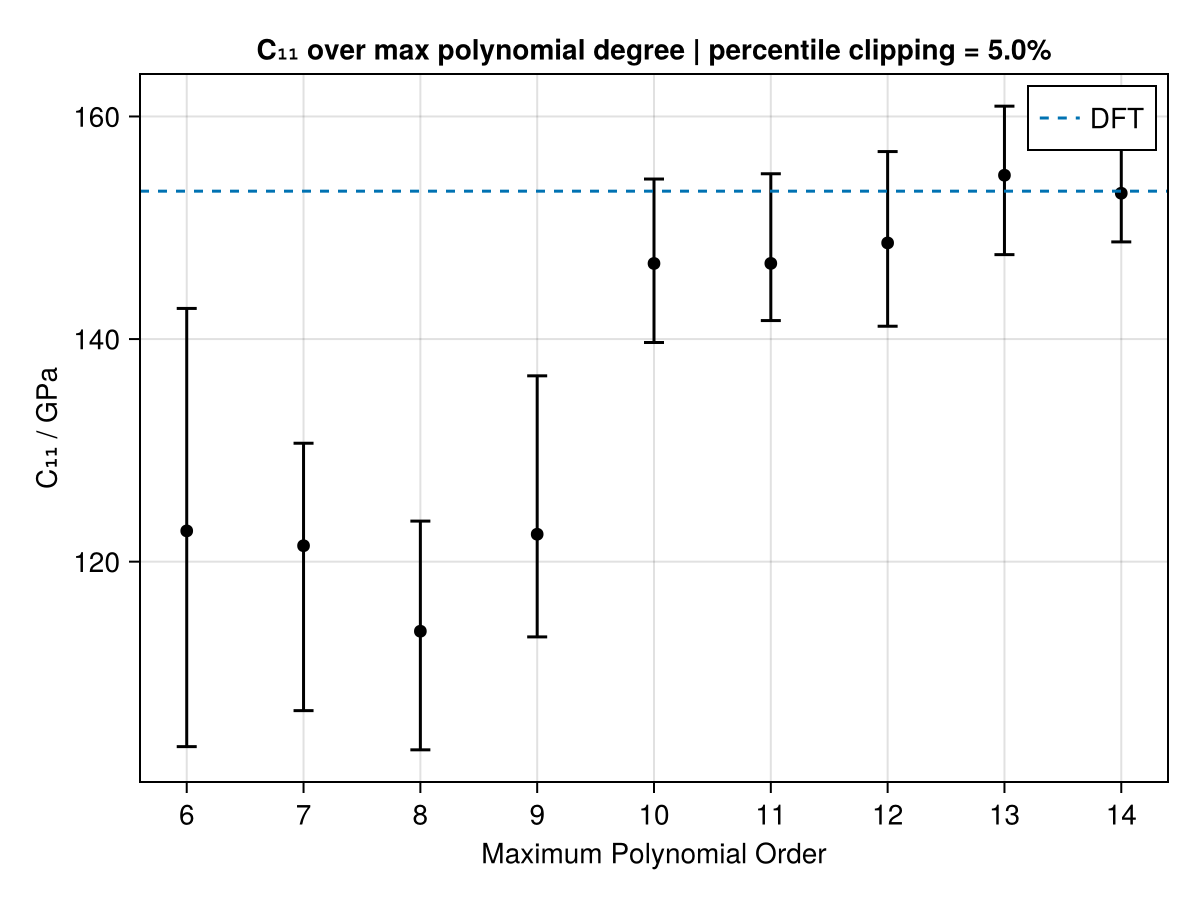

In [661]:
fig = QoI_over_P_plotter(ace_C11_v_P, ace_C11_v_P_max_min, percentile_clipping, "C₁₁", "C11", gap_C11, "GPa")
fig

In [10]:
function _flexiblesystem(sys) 
   c3ll = cell(sys)
   particles = [ AtomsBase.Atom(species(sys, i), position(sys, i)) 
                 for i = 1:length(sys) ] 
   return FlexibleSystem(particles, c3ll)
end; 

In [11]:
function deformation_E(model)
    ucell = bulk(:Si, cubic=true)
    ucell, _ = GeomOpt.minimise(ucell, model; variablecell=true, verbose=0);
    Eperat = potential_energy(ucell, model) / length(ucell)
    sys = _flexiblesystem(ucell) * (2,2,2)
    deleteat!(sys, 1)
    vacancy_equil, result = GeomOpt.minimise(sys, model; variablecell = false)
    E_def = potential_energy(vacancy_equil, model) - length(sys) * Eperat
    return E_def
end

deformation_E (generic function with 1 method)

In [13]:
E_defs = []
for i = 0:length(co_ps_vec)
    if (i == 0)
        model_ind = model
    else
        model_ind = deepcopy(model_outline)
        ACEpotentials.Models.set_linear_parameters!(model_ind, co_ps_vec[i]);
    end
    E_def = deformation_E(model_ind)
    append!(E_defs, E_def)
end

┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028028e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 6.56e-28 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.51e-27 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.46e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    22
    f(x) calls:    55
    ∇f(x) calls:   23



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028036e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 2.42e-27 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.65e-26 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.91e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    22
    f(x) calls:    57
    ∇f(x) calls:   23



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028078e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 4.54e-28 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.24e-27 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.32e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    19
    f(x) calls:    50
    ∇f(x) calls:   20



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028057e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.47e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.00e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.95e-15 ≰ 0.0e+00
    |g(x)|                 = 6.36e-07 ≤ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    19
    f(x) calls:    40
    ∇f(x) calls:   20



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028037e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.90e-19 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.38e-18 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.16e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    18
    f(x) calls:    48
    ∇f(x) calls:   19



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.027965e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.94e-26 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.28e-25 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.65e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    21
    f(x) calls:    51
    ∇f(x) calls:   22



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028031e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 4.34e-19 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.86e-18 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.89e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    46
    ∇f(x) calls:   21



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028067e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 2.42e-27 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.72e-26 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.95e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    19
    f(x) calls:    47
    ∇f(x) calls:   20



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028059e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.62e-27 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.10e-26 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.64e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    21
    f(x) calls:    51
    ∇f(x) calls:   22



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028050e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 2.02e-28 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.50e-27 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.00e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    23
    f(x) calls:    62
    ∇f(x) calls:   24



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028007e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 9.55e-26 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.04e-25 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.36e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    23
    f(x) calls:    55
    ∇f(x) calls:   24



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028015e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 3.17e-26 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.39e-25 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.31e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    22
    f(x) calls:    58
    ∇f(x) calls:   23



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.027973e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 2.78e-17 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.01e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    49
    ∇f(x) calls:   21



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028030e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.87e-26 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.30e-25 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.87e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    51
    ∇f(x) calls:   21



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028067e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 4.04e-28 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.18e-27 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.82e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    21
    f(x) calls:    53
    ∇f(x) calls:   22



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028016e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 3.47e-18 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.47e-17 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.34e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    18
    f(x) calls:    47
    ∇f(x) calls:   19



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028052e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 4.87e-27 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.33e-26 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.09e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    19
    f(x) calls:    45
    ∇f(x) calls:   20



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028100e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 4.34e-19 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.06e-18 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.31e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    18
    f(x) calls:    45
    ∇f(x) calls:   19



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.027990e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 3.11e-26 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.25e-25 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.45e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    50
    ∇f(x) calls:   21



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028055e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.01e-27 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.39e-27 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.55e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    23
    f(x) calls:    53
    ∇f(x) calls:   24



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028046e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 2.02e-28 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.46e-27 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.17e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    53
    ∇f(x) calls:   21



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028046e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.31e-27 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.34e-27 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.78e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    19
    f(x) calls:    49
    ∇f(x) calls:   20



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028098e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.08e-19 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.75e-19 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.06e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    21
    f(x) calls:    53
    ∇f(x) calls:   22



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028041e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 4.34e-19 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.18e-18 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.86e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    15
    f(x) calls:    43
    ∇f(x) calls:   16



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028004e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 3.80e-26 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.72e-25 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.50e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    24
    f(x) calls:    55
    ∇f(x) calls:   25



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028038e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 2.08e-28 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.55e-27 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.41e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    23
    f(x) calls:    57
    ∇f(x) calls:   24



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028047e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 2.17e-19 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.53e-18 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.91e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    23
    f(x) calls:    53
    ∇f(x) calls:   24



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.027970e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.29e-25 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.87e-25 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.20e-05 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    19
    f(x) calls:    46
    ∇f(x) calls:   20



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.027968e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.26e-29 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.16e-29 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.71e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    22
    f(x) calls:    53
    ∇f(x) calls:   23



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.028064e+04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.34e-06 ≰ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    51
    ∇f(x) calls:   20



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120
┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (0.0) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/7krni/src/types.jl:120


LoadError: InterruptException:

In [255]:
E_clipped = filter(x -> abs(x - mean(E_defs)) ≤ std(E_defs), E_defs[2:end])
E_defs[1], 2 * std(E_clipped)
mean(E_defs), 2 * std(E_defs)

(-3.9435894527214136e32 eV, 1.9318757785910253e33 eV)